In [1]:
import av
import sounddevice as sd

import itertools

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch
from torch import nn
DEVICE=torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

import torchaudio
from torchaudio.transforms import MelSpectrogram, Spectrogram, AmplitudeToDB, MelScale, InverseMelScale, GriffinLim, InverseSpectrogram
from torchvision.transforms import Resize, InterpolationMode
import random

import pandas as pd

#from models import *
import gc
import time
from importlib import reload
import utils
_=reload(utils)
from utils import *
import os

n_fft: 480
win_length: 480
hop_length: 383
n_fft: 480
win_length: 480
hop_length: 383


In [2]:
import torch
torch.__version__

'2.7.0+cu126'

In [3]:
T=T.to(DEVICE)
I=I.to(DEVICE)

In [4]:
n_fft = 1024#600
n_mels = 64#22
n_stft=n_fft//2+1
win_length = n_fft
hop_length = win_length//2
# T0: waveform -> spectrogram
# I0: spectrogram -> waveform
T0=Spectrogram(power=None, n_fft=n_fft, win_length=win_length, hop_length=hop_length).to(DEVICE)
I0=InverseSpectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length).to(DEVICE)
M0T=MelScale(n_mels=n_mels,n_stft=n_stft,sample_rate=SR).to(DEVICE)
M0I=InverseMelScale(n_mels=n_mels,n_stft=n_stft,sample_rate=SR).to(DEVICE)
assert (not bool(M0I(M0T(T0(torch.randn(2,10000).cuda()).abs())).sum().isnan())), "incompatible config"

In [5]:
print("DEVICE:",DEVICE)

DEVICE: cuda:0


In [28]:
target_files = [
    #get_canonical_filename('./data/uncompressed/podcast_titikkumpul1/cut_podcast_20250227_1_titikkumpul_kotadiindonesiayangnyaman.mp3'),
]
noise_files = []
prefix='./data/uncompressed/DAPS_clean_wav/'
for _,_,filenames in (os.walk(prefix)):
    target_files+=[get_canonical_filename(prefix+f) for f in filenames]
prefix='./data/uncompressed/kaggle_audioNoiseDataset/'
for _,_,filenames in (os.walk(prefix)):
    noise_files+=[get_canonical_filename(prefix+f) for f in filenames]
# prefix=r'./data/uncompressed/ESC-50-master/ESC-50-master/audio/'
# for _,_,filenames in (os.walk(prefix)):
#     noise_files+=[get_canonical_filename(prefix+f) for f in filenames]
# prefix=r'./data/uncompressed/urbandsound_8k_fold1_flattened/'
# for _,_,filenames in (os.walk(prefix)):
#     noise_files+=[get_canonical_filename(prefix+f) for f in filenames]
# prefix=r'./data/uncompressed/short_noises//'
# for _,_,filenames in (os.walk(prefix)):
#     noise_files+=[get_canonical_filename(prefix+f) for f in filenames]
misc_files = [
    # get_canonical_filename("./data/uncompressed/sine_sweep/sine_sweep.mp3"),
    # get_canonical_filename("./data/uncompressed/countdown/cd20_cleaned.mp3"),
    #get_canonical_filename("./data/uncompressed/misc/noisy_podcast.wav"),
    #get_canonical_filename("./data/uncompressed/misc/noisy_podcast2.wav"),
]
audio_files = target_files + noise_files + misc_files

In [29]:
it=tqdm(audio_files)
for filename in it:
    it.set_description(f"processing {filename.split('data')[-1][1:]}")
    for _ in stream_audio(file_path=filename,use_cache=True,use_torch=False):
        pass
    

  0%|          | 0/110 [00:00<?, ?it/s]

In [5]:

def to_pair(x):
    """Convert an int or tuple into a pair (x, x) if needed."""
    if isinstance(x, int):
        return (x, x)
    elif isinstance(x, (tuple, list)) and len(x) == 2:
        return tuple(x)
    else:
        raise ValueError("Parameter must be an int or a tuple of two ints.")

def conv2d_output_dim(input_dim, kernel_size, stride, padding, dilation):
    """
    Computes the output dimension for a single spatial axis in Conv2d.
    Formula: floor((input + 2*padding - dilation*(kernel_size-1) - 1) / stride) + 1
    """
    return (input_dim + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

def convtranspose2d_output_dim(conv_out_dim, kernel_size, stride, padding, dilation, output_padding=0):
    """
    Computes the output dimension for a single spatial axis in ConvTranspose2d.
    Formula: (conv_out_dim - 1)*stride - 2*padding + dilation*(kernel_size-1) + output_padding + 1
    """
    return (conv_out_dim - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1

def is_invertible_2d(input_height, input_width, kernel_size, stride, padding, dilation, output_padding=0):
    """
    Checks whether a Conv2d with the given parameters (which can be int or tuple)
    is invertible by a ConvTranspose2d (with output_padding=0) in terms of spatial dimensions.
    
    Returns:
        invertible (bool): True if both height and width are exactly recovered.
        conv_out_shape (tuple): (output_height, output_width) from the forward conv.
        recovered_shape (tuple): (recovered_height, recovered_width) from the transposed conv.
    """
    # Convert parameters to pairs (height, width)
    kernel_h, kernel_w   = to_pair(kernel_size)
    stride_h, stride_w   = to_pair(stride)
    pad_h, pad_w         = to_pair(padding)
    dilation_h, dilation_w = to_pair(dilation)
    output_padding_h, output_padding_w = to_pair(output_padding)
    
    # Compute forward conv output dimensions
    out_h = conv2d_output_dim(input_height, kernel_h, stride_h, pad_h, dilation_h)
    out_w = conv2d_output_dim(input_width,  kernel_w, stride_w, pad_w, dilation_w)
    
    # Compute reconstructed dimensions using ConvTranspose2d formulas (output_padding=0)
    rec_h = convtranspose2d_output_dim(out_h, kernel_h, stride_h, pad_h, dilation_h, output_padding=output_padding_h)
    rec_w = convtranspose2d_output_dim(out_w, kernel_w, stride_w, pad_w, dilation_w, output_padding=output_padding_w)
    
    invertible = (rec_h == input_height) and (rec_w == input_width)
    return invertible, (out_h, out_w), (rec_h, rec_w)

In [6]:
def save_model(
    name, 
    model, 
    optimizer=None, 
    scheduler=None, 
    arch=None, 
    last_epoch=None,
    loss_record=None, 
    loss_metric=None,
    total_training_iters=None,
    last_target_name=None, 
    last_batch_size=None,
    last_dataset_name=None,
    tag_uuid=True,
    or_tag_date=True,
    allow_overwrite=False,
    prefix='saves',
):
    import inspect
    if tag_uuid:
        import uuid
        name=name+'-'+uuid.uuid4().hex[:6]
    elif or_tag_date:
        import datetime
        suffix=datetime.datetime.now().strftime("%y%m%d")
        name=name+'-'+suffix
    if os.path.exists(os.path.join(prefix,name)) and not allow_overwrite:
        raise FileExistsError("File/dir already exists")
    elif not allow_overwrite:
        os.makedirs(os.path.join(prefix,name))
    #with open(os.path.join('saves',name,"source_code.py")) as f:
    #    f.write(inspect.getsource(instance))
    checkpoint = {
        'last_epoch': last_epoch,  # current training epoch
        'loss_record': loss_record if loss_record is not None else dict(),  
        'loss_metric': loss_metric, 
        'last_target_name': last_target_name,  
        'total_training_iters': total_training_iters,  # total_training_iters
        'arch': arch, 
        'last_batch_size': last_batch_size, 
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict() if optimizer is not None else None,
        'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
        'config': model.get_config(),  # a dict of hyperparameters
        'arch': arch if arch is not None else type(model).__name__,      # e.g., obtained via subprocess from git
        # Optionally add any additional info (loss, metrics, etc.)
    }
    
    torch.save(checkpoint, os.path.join(prefix,name,'checkpoint.pth'))
    
class TrainingContext:
    def __init__(self, cls, *args, **kwargs):
        self.inner = cls(*args, **kwargs).to(DEVICE)
        self.name = cls.__name__
        self.optim = torch.optim.AdamW(self.inner.parameters())
        self.sched = torch.optim.lr_scheduler.ExponentialLR(self.optim, gamma=0.9)
        self.num_parameters = sum(map(torch.numel,self.inner.parameters()))
        self.train_loss_record = dict()
        self.test_loss_record = dict()
        self.results = list()
        self.total_iters = 0
        self.running_loss = 0
        self.best_eval_loss = 999
        self.stopped = False
        self.batch_size=64
        self.train_loss_metric='L1'
        self.eval_loss_metric='L1'
        self.last_target_name='clamped mel-spectrogram'
        self.last_dataset_name='miscellaneous'
        self.training=True
    def __call__(self, *args, **kwargs):
        return self.inner(*args, **kwargs)
    def __getattr__(self, name):
        return self.inner.__getattribute__(name)
    def save(self, prefix='saves'):
        save_model(
            self.name,
            self.inner,
            optimizer=self.optim,
            scheduler=self.sched,
            loss_record={
                'train':self.train_loss_record,
                'test':self.test_loss_record,
            },
            total_training_iters=self.total_iters,
            last_batch_size=self.batch_size,
            loss_metric={
                'train':'MSE',
                'test':'MAE',
            },
            last_target_name=self.last_target_name,
            last_dataset_name=self.last_dataset_name
        )
    @classmethod
    def load(cls, name, class_, prefix='saves', training=False):
        checkpoint=torch.load(os.path.join(prefix,name,'checkpoint.pth'),map_location=DEVICE)
        self=cls(class_,**checkpoint['config'])
        self.inner.load_state_dict(checkpoint['model_state_dict'])
        self.optim.load_state_dict(checkpoint['optimizer_state_dict'])
        self.sched.load_state_dict(checkpoint['scheduler_state_dict'])
        self.total_iters=checkpoint['total_training_iters']
        self.batch_size=checkpoint['last_batch_size']
        self.train_loss_record=checkpoint['loss_record']['train']
        self.test_loss_record=checkpoint['loss_record']['test']
        self.best_eval_loss=min(self.test_loss_record.values()) if len(self.test_loss_record.values())>0 else None
        self.training=training
        return self

In [7]:
shape=(64, 64)
print(shape)
kernel_sizes = (
    3,
    3,
    3,
    3,
)
strides = (
    2,
    2,
    2,
    2,
)
output_paddings = (
    1,
    1,
    1,
    1,
)
padding= (
    1,
    1,
    1,
    1,
)
dilation=1
for k,s,p,o in zip(kernel_sizes, strides, padding, output_paddings):
    inv, shape, rec = is_invertible_2d(*shape, k, s, p, dilation, o)
    print(f'{k}@{s}+{p}:{shape} => ',rec)
    assert inv

(64, 64)
3@2+1:(32, 32) =>  (64, 64)
3@2+1:(16, 16) =>  (32, 32)
3@2+1:(8, 8) =>  (16, 16)
3@2+1:(4, 4) =>  (8, 8)


In [33]:
import random
#f=random.choice(audio_files)
#print(f)
s=stream_random_audio_buffer(target_files[:], buffer_size=SR*4)
#s=stream_audio(target_files[2],skip_samples=SR*10, buffer_size=SR*5)
#print(target_files[2])
for a,r in s:
    #a=a[...,:SR//20]
    print(a.shape,r)
    play_audio(a,SR)
    break

torch.Size([1, 192000]) 48000


In [18]:
play_audio(a[...,:],SR)

In [46]:
a.shape[-1]/win_length

187.5

In [52]:
T0(a[:,:hop_length+1].to(DEVICE)).shape

torch.Size([1, 513, 2])

In [53]:
T0(a[:,:150*win_length].to(DEVICE)).shape

torch.Size([1, 513, 301])

In [63]:
def rand_freq_mask_factory():
    from torchaudio.transforms import FrequencyMasking
    return FrequencyMasking(freq_mask_param=3)
def rand_freq_mask(spec):
    if torch.rand([])<0.5:
        return rand_freq_mask_factory()(spec)
    return spec

In [64]:
def rand_time_mask_factory():
    from torchaudio.transforms import TimeMasking
    return TimeMasking(time_mask_param=3)
def rand_time_mask(spec):
    if torch.rand([])<0.5:
        return rand_time_mask_factory()(spec)
    return spec

In [65]:
def rand_time_stretch_factory():
    from torchaudio.transforms import TimeStretch
    return TimeStretch(hop_length=hop_length, n_freq=n_fft//2+1).to(DEVICE)
def rand_time_stretch(comp_spec):
    if torch.rand([])<0.2:
        return rand_time_stretch_factory()(comp_spec, overriding_rate=float(torch.rand([]))*0.5+0.75)
    return comp_spec

In [30]:
def augment(waveform):
    complex_spectrogram = T0(waveform.to(DEVICE))
    complex_spectrogram = rand_time_stretch(complex_spectrogram)
    phase = complex_spectrogram.angle()
    mag = complex_spectrogram.abs().log1p()#TODO: this is WRONG
    mel_spectrogram = M0T(mag)#TODO: THIS should be the place after which .log1p is called
    mel_spectrogram = rand_time_mask(mel_spectrogram)
    mel_spectrogram = rand_time_mask(mel_spectrogram)
    mel_spectrogram = rand_freq_mask(mel_spectrogram)
    mel_spectrogram = rand_freq_mask(mel_spectrogram)
    return mel_spectrogram

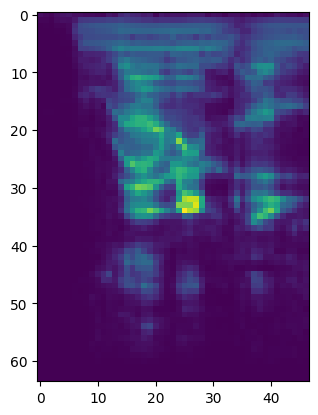

In [95]:
imshow(M0T(T0(a.to(DEVICE)[:,:int(0.5*SR)]).abs().log1p())[0])

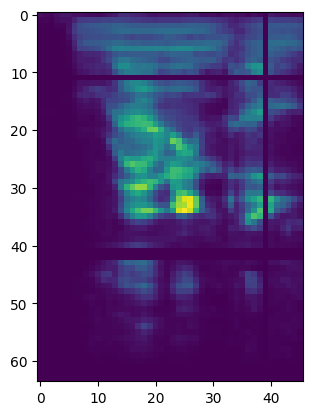

In [104]:
imshow(augment(a[:,:int(0.5*SR)])[0])

In [87]:
augmented_combined_logmag_mel.shape

torch.Size([1, 64, 39])

In [20]:
def play_spec(spec,phase):
    return play_audio(I0(torch.polar(spec,phase)),SR)

In [21]:
def play_mel(mel, phase):
    return play_spec(M0I(mel),phase)

In [8]:
import gruunet2
reload(gruunet2)
from   gruunet2 import GRUUNet2
from gruunet import GRUUNet
#model=ConvMLP(2,[40,16],2,3,stride=1, padding=2)
#model1=UNet1d()#AudioModel(2, [45,10,2])
#model2=UNet2d()#AudioModel(2, [45,10,2])
model=TrainingContext(GRUUNet2,
    num_compressed_bins = 4,
    in_size = 1,   
    hidden_sizes =    (17, 17, 17, 17),
    kernel_sizes =    (3, 3, 3, 3),
    strides =         (2, 2, 2, 2),
    paddings=         (1, 1, 1, 1),
)
model=TrainingContext.load("GRUUNet2-dari_tult",GRUUNet2)
#model.load_state_dict(torch.load("good_small_model2.pth"))
#model=torch.compile(model)
#torch.save(model.state_dict(),"test.pth")
#optimizer=torch.optim.AdamW(model.parameters(),lr=1e-3)

In [21]:
model.save()

In [143]:
a,b=model(torch.randn(
    1, 1, 64
).to(DEVICE))
#a,b=model(
#    a,b
#)
a.shape,b.shape

(torch.Size([1, 1, 64]), torch.Size([1, 17, 4]))

In [144]:
a,b=model(torch.randn(
    1, 64
).to(DEVICE))
display(a.shape, b.shape)
a,b=model(
    a,b
)
a.shape,b.shape

torch.Size([1, 64])

torch.Size([1, 17, 4])

(torch.Size([1, 64]), torch.Size([1, 17, 4]))

In [157]:
n_epochs=100000
TRAINING=True
IGNORE_PADS=1
running_loss=0
running_loss_window=200
BATCH_SIZE=8
BUFFER_SIZE=int(SR)#9958
running_abs_diff = 0
running_abs_sig = 0
running_abs_combined = 0
n = 0
eps=1e-9

In [194]:
target_gen = stream_random_audio_buffer(target_files, buffer_size=BUFFER_SIZE*BATCH_SIZE,max_samples=float('inf'))#(stream_audio(target_file, buffer_size=SR, skip_samples=11*SR))
noise_gen_a  = stream_random_audio_buffer(noise_files, buffer_size=BUFFER_SIZE*BATCH_SIZE,max_samples=float('inf')) #(stream_audio(noise_file, buffer_size=SR, skip_samples=11*SR))
noise_gen_b  = stream_random_audio_buffer(noise_files, buffer_size=BUFFER_SIZE*BATCH_SIZE,max_samples=float('inf')) #(stream_audio(noise_file, buffer_size=SR, skip_samples=11*SR))
with tqdm(total=n_epochs) as epoch_i:
    epoch_i.reset(n_epochs)
    for epochs, ((target_samples, sr1), (noise_samples_a, sr2), (noise_samples_b, sr2))  in zip(range(n_epochs), zip(target_gen, noise_gen_a, noise_gen_b)):
        target_samples=target_samples.to(DEVICE).mean(0).unsqueeze(0).view(BATCH_SIZE,-1) # waveform
        noise_samples_a=noise_samples_a.to(DEVICE).mean(0).unsqueeze(0).view(BATCH_SIZE,-1) # waveform
        noise_samples_b=noise_samples_b.to(DEVICE).mean(0).unsqueeze(0).view(BATCH_SIZE,-1) # waveform
        
        _x = torch.linspace(0,1,target_samples.shape[-1]).view(1,-1).repeat(target_samples.shape[-2],1).to(DEVICE)
        _a = torch.rand([])*10
        mask_a=torch.pow(_x,_a)/(torch.pow(_x,_a)+torch.pow(1-_x,_a))
        mask_b=1-mask_a
        rn=torch.rand([])*1.5 # rn [0.3, 0.6] -> idk 0<x<1
        rs=torch.rand([])+0.5
        noise_samples=(mask_a*noise_samples_a+mask_b*noise_samples_b)*rn
        
        target_waveform = target_samples*rs
        
        augmented_noise_logmag_mel = augment(noise_samples)
        augmented_signal_logmag_mel = augment(target_waveform)[...,:augmented_noise_logmag_mel.shape[-1]]
        augmented_noise_logmag_mel = augmented_noise_logmag_mel[...,:augmented_signal_logmag_mel.shape[-1]]
        augmented_combined_logmag_mel = (augmented_signal_logmag_mel.exp()-1+augmented_noise_logmag_mel.exp()-1).log1p()
        augmented_diff_logmag_mel = augmented_combined_logmag_mel-augmented_signal_logmag_mel
        
        if TRAINING:
            out, h = model(augmented_combined_logmag_mel.transpose(-1,-2))
            out = nn.functional.leaky_relu(out.transpose(-1,-2),negative_slope=0.2)
            ##loss = (out-logmag_diff).abs().mean()
            #if out.shape!=logmag_diff.shape: continue
            diff=(out-augmented_diff_logmag_mel)
            scaled_diff=diff*augmented_combined_logmag_mel 
            loss=(scaled_diff.abs()).mean()
            loss_ = float(loss.item())*100
            model.running_loss = (1/running_loss_window)*loss_+(1-1/running_loss_window)*model.running_loss
            #absdiff=(out-y).abs()
            #abssig=y.abs()
            #abscom=combined.abs()
            #n+=1
            #running_abs_diff=running_abs_diff+(absdiff-running_abs_diff)/n 
            #running_abs_sig=running_abs_sig+(abssig-running_abs_sig)/n 
            #running_abs_combined=running_abs_combined+(abscom-running_abs_combined)/n 
            if epochs+1>=1.1**len(model.train_loss_record):
                model.train_loss_record[model.total_iters]=loss_
            if len(model.train_loss_record)<=3:
                model.running_loss = (model.running_loss*.3+loss_*.7)
            #print("running loss:",model.running_loss)
            model.zero_grad(set_to_none=True)
            loss.backward()
            model.optim.step()
            epoch_i.set_description(f'running SSE={model.running_loss:.2f}')
            model.total_iters+=1
        else:
            if rn < 0.35 : continue
            #rn=(rn+0.3)/2.0
            with torch.no_grad():
                out, h = model(combined_logmag.transpose(-1,-2))
                out = out.transpose(-1,-2)
                _out=combined_logmag+out
            _out=torch.polar(_out.exp(),phase)
            epoch_i.set_description(f"playing combined random-strength: {int(rn*100)}")
            play_audio(noise_samples*rn+target_samples*(1-rn), sr1)
            time.sleep(0.2)
            epoch_i.set_description("playing out")
            play_audio(I(_out.cpu()), sr1)
            time.sleep(0.2)
            epoch_i.set_description("playing target")
            play_audio(target_samples*(1-rn), sr1)
            time.sleep(0.5)
        epoch_i.update(1)#spectrogram.unflatten(0,(-1,2)).permute(1,2,3,0)

  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [195]:
model.save()

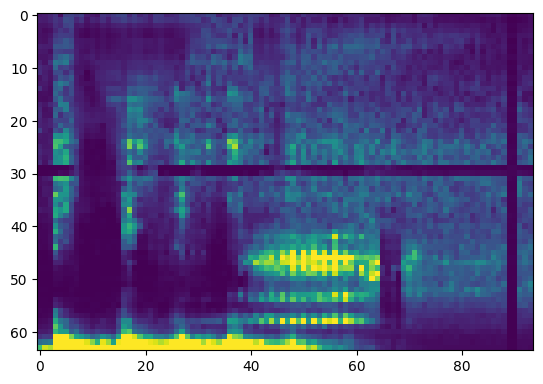

In [196]:
imshow(out[0],vmin=0,vmax=7.5)

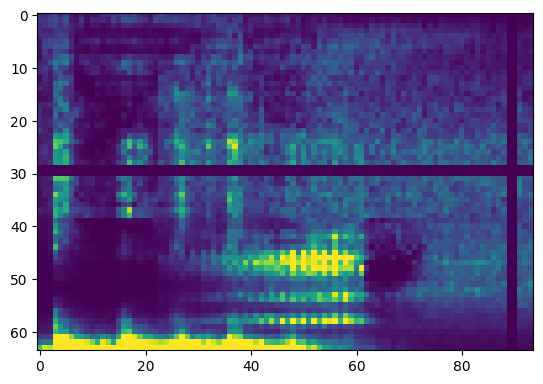

In [197]:
imshow(augmented_diff_logmag_mel[0],vmin=0,vmax=7.5)

In [190]:
target_waveform.shape

torch.Size([8, 48000])

In [192]:
play_audio(target_waveform[1],SR)

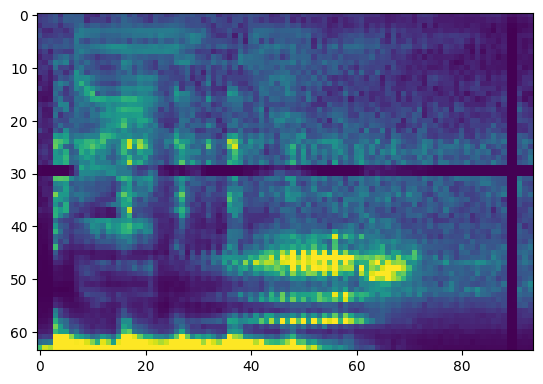

In [198]:
imshow(augmented_combined_logmag_mel[0],vmin=0,vmax=7.5)

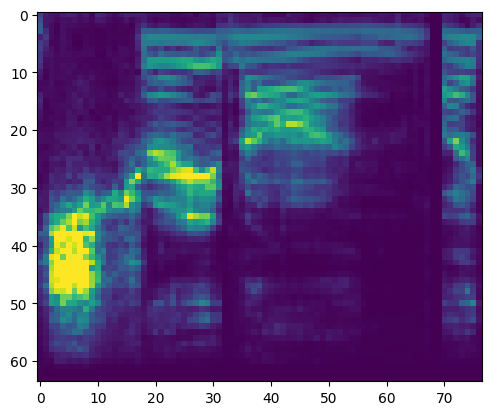

In [188]:
imshow(augmented_signal_logmag_mel[0],vmin=0,vmax=7.5)

In [ ]:
mo

In [177]:
print(augmented_diff_logmag_mel.quantile(0))
print(augmented_diff_logmag_mel.quantile(0.01))
print(augmented_diff_logmag_mel.quantile(0.1))
print(augmented_diff_logmag_mel.quantile(0.5))
print(augmented_diff_logmag_mel.quantile(0.9))
print(augmented_diff_logmag_mel.quantile(0.95))
print(augmented_diff_logmag_mel.quantile(0.99))
print(augmented_diff_logmag_mel.quantile(1))


tensor(0.0004, device='cuda:0')
tensor(0.0046, device='cuda:0')
tensor(0.6095, device='cuda:0')
tensor(2.1642, device='cuda:0')
tensor(5.9508, device='cuda:0')
tensor(7.5450, device='cuda:0')
tensor(10.0536, device='cuda:0')
tensor(21.2616, device='cuda:0')


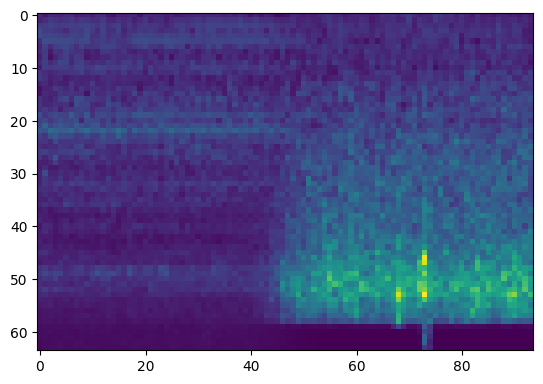

In [182]:
imshow(augmented_noise_logmag_mel[0])

In [53]:
augmented_diff_logmag_mel[0].max()

tensor(11.8292, device='cuda:0')

In [31]:
augment(stacked_samples)

torch.Size([2, 1, 64, 40])

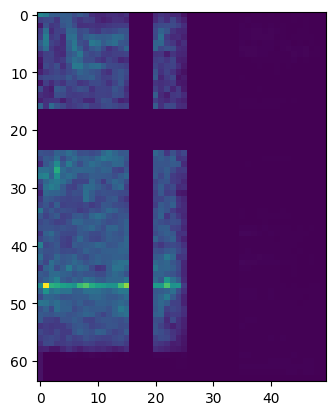

In [35]:
imshow(augmented_stacked_logmag_mel[0,0])

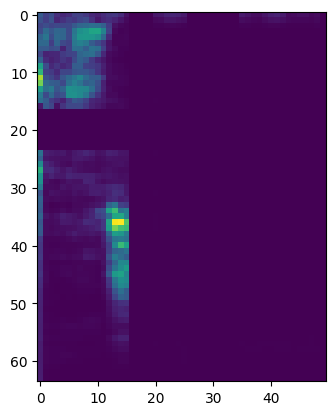

In [36]:
imshow(augmented_stacked_logmag_mel[1,0])

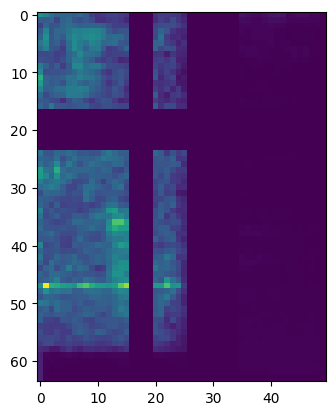

In [38]:
imshow((augmented_stacked_logmag_mel[0,0].exp()-2+augmented_stacked_logmag_mel[1,0].exp()).log1p())

In [43]:
tmp=((augmented_stacked_logmag_mel[0,0].exp()-2+augmented_stacked_logmag_mel[1,0].exp()).log1p()/augmented_stacked_logmag_mel[2,0])
tmp[~tmp.isnan()].mean()

tensor(1.1038, device='cuda:0')

In [44]:
tmp=((augmented_stacked_logmag_mel[0,0].exp()-2+augmented_stacked_logmag_mel[1,0].exp()).log1p()-augmented_stacked_logmag_mel[2,0])
tmp[~tmp.isnan()].mean()

tensor(0.0205, device='cuda:0')

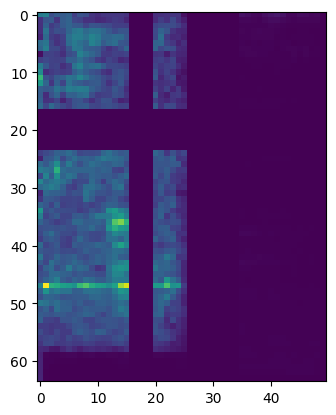

In [37]:
imshow(augmented_stacked_logmag_mel[2,0])

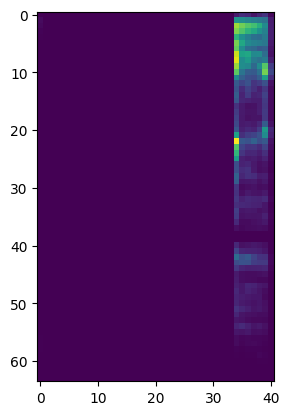

In [112]:
imshow(augmented_signal_logmag_mel[0])

In [64]:
model.save()

<Axes: ylabel='Frequency'>

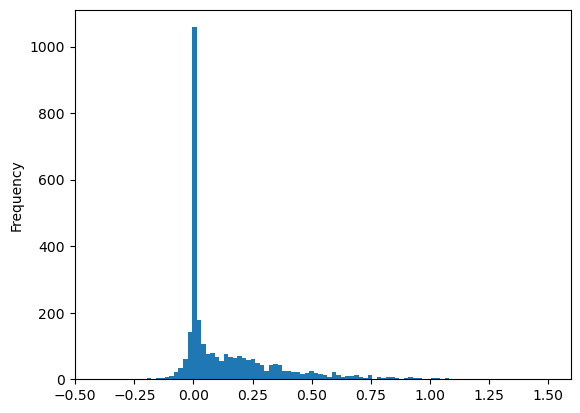

In [94]:
pd.Series(logmag_diff.cpu().detach().numpy().flatten()).plot.hist(bins=100)

<Axes: ylabel='Frequency'>

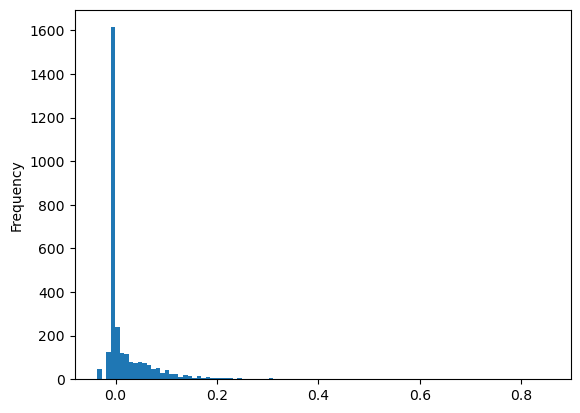

In [123]:
pd.Series((out).cpu().detach().numpy().flatten()).plot.hist(bins=100)

Text(0.5, 1.0, 'training di lab 20/05/2025, GRUUnet2, 3x17x3x2x1')

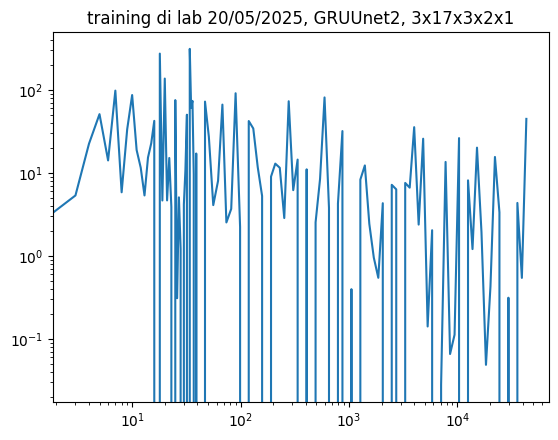

In [65]:
pd.Series(model.train_loss_record).plot()
plt.xscale('log')
plt.yscale('log')
plt.title("training di lab 20/05/2025, GRUUnet2, 3x17x3x2x1")

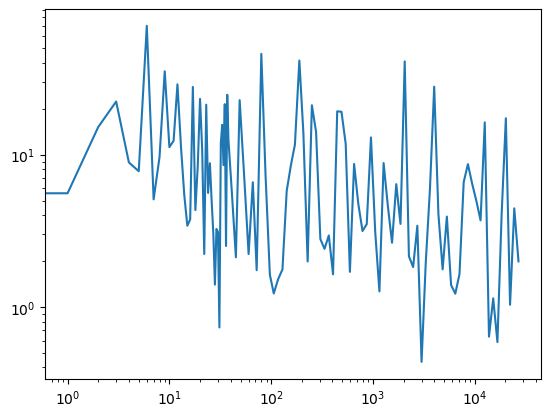

In [124]:
pd.Series(model.train_loss_record).plot()
plt.xscale('log')
plt.yscale('log')

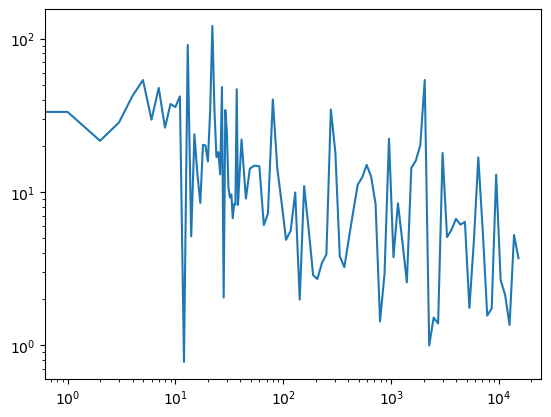

In [49]:
pd.Series(model.train_loss_record).plot()
plt.xscale('log')
plt.yscale('log')

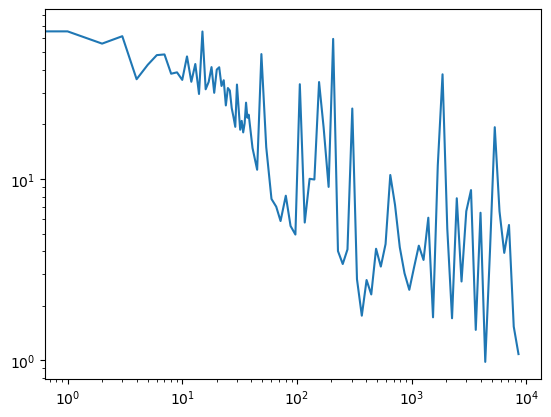

In [222]:
pd.Series(model.train_loss_record).plot()
plt.xscale('log')
plt.yscale('log')

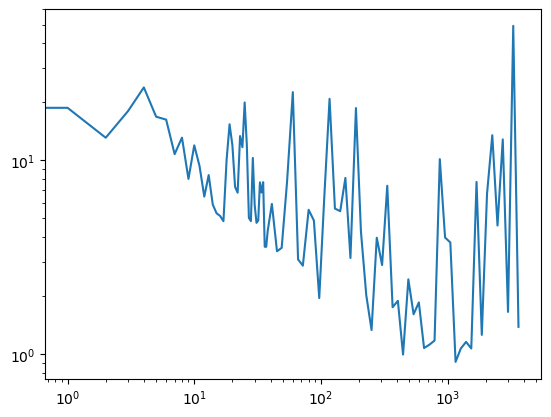

In [63]:
pd.Series(model.train_loss_record).plot()
plt.xscale('log')
plt.yscale('log')

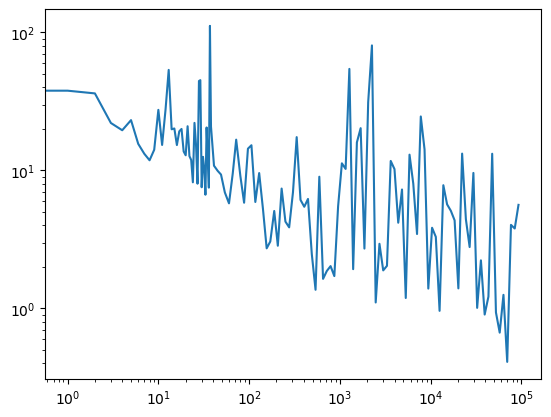

In [267]:
pd.Series(model.train_loss_record).plot()
plt.xscale('log')
plt.yscale('log')

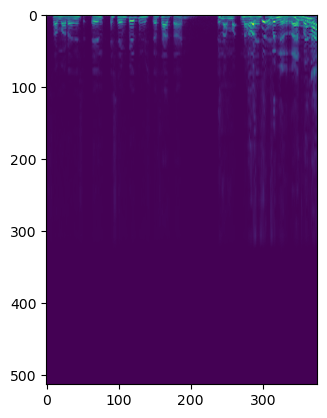

In [257]:
imshow((flattened_truth.abs().log1p())[0])

In [125]:
model.save()

In [66]:
def flatten(x, phase):
    return torch.polar(M0I(torch.cat(x,-1).exp()-1), phase)

In [67]:
for s,sr in stream_audio(noise_files[0],buffer_size=LENGTH,limit_samples=LENGTH):
    play_audio(s,sr)
    break

NameError: name 'LENGTH' is not defined

In [74]:
misc_files[3]

'C:\\Users\\umarzein\\Desktop\\audio_codec\\data\\uncompressed\\misc\\noisy_podcast2.wav'

In [9]:
LENGTH=6*SR
g1=stream_random_audio_buffer(target_files,buffer_size=LENGTH,max_samples=LENGTH)
g2=stream_random_audio_buffer(noise_files,buffer_size=LENGTH,max_samples=LENGTH)
truth=[]
best_possible=[]
zz=[]
perceived=[]
prediction=[]
wsignal=[]
wnoise=[]
tmps=[]
phases = []
rn=torch.rand([])*0.2
#rn=1.0
print("rn:",rn)
for i, ((target, sr1), (noise, sr2))  in tqdm(enumerate(zip(g1, g2))):
    target=target.to(DEVICE)
    noise=noise.to(DEVICE)
    if i>1_000: break
    #print("target:",target.shape)
    #print("noise:",noise.shape)
    __combined=T0(noise*rn+target*(1-rn)).to(DEVICE)
    phase=__combined.angle()
    magn = __combined.abs()
    phases.append(phase)
    combined = M0T(magn).log1p()
    signal = T0(target*(1-rn)).to(DEVICE).abs()
    signal = M0T(signal).log1p()
    #y = (T(noise*rn+target*(1-rn)).abs()).to(DEVICE)-
    with torch.no_grad():
        out, _ = model(combined.transpose(-1,-2))
        out = nn.functional.leaky_relu(out.transpose(-1,-2),negative_slope=0.2)
    best_possible.append(M0I(signal.exp()-1))
    truth.append(signal)
    wnoise.append(noise.cpu())
    wsignal.append(target.cpu())
    #zz.append(z)
    #truth2.append(target)
    perceived.append(combined)
    #prediction.append(M0I((out+(combined)).exp()-1))
    prediction.append(M0I((combined-out).exp()-1))
    # i think i know why our model is bad: look at how out+combined is dome before M0I
    # i think we should try for magn+M0I(out)
flattened_phase = torch.cat(phases,-1)
flattened_noise=torch.cat(wnoise, -1)
flattened_signal=torch.cat(wsignal, -1)
flattened_truth=torch.polar(M0I(torch.cat(truth,-1).exp()-1), flattened_phase)#flatten(truth, flattened_phase)
#flattened_tmps=torch.cat(tmps,-1)
#flattened_zz=torch.cat(zz,-1)
flattened_best_possible=torch.polar((torch.cat(best_possible,-1)), flattened_phase)
flattened_perceived=torch.polar(M0I(torch.cat(perceived,-1).exp()-1), flattened_phase)#flatten(perceived, flattened_phase)
flattened_prediction=torch.polar((torch.cat(prediction,-1)), flattened_phase)#flatten(prediction, flattened_phase)


NameError: name 'target_files' is not defined

In [84]:
play_audio(flattened_signal,SR)

In [101]:
play_audio(I0(flattened_perceived), SR)

In [102]:
play_audio(I0(flattened_prediction), SR)

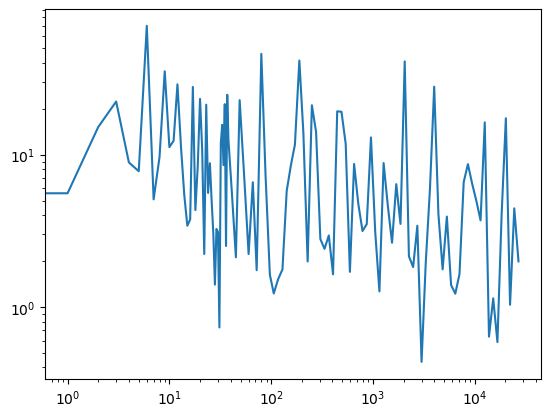

In [152]:
pd.Series(model.train_loss_record).plot()
plt.xscale('log')
plt.yscale('log')

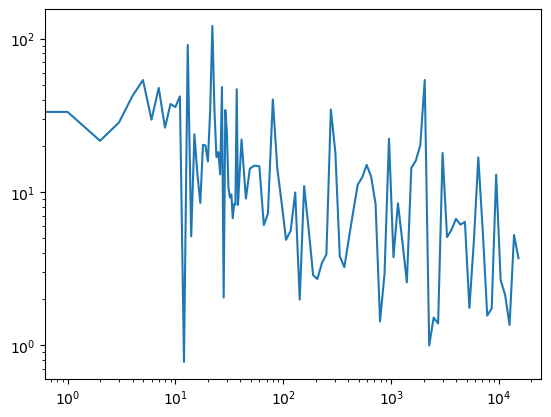

In [149]:
pd.Series(grunet.train_loss_record).plot()
plt.xscale('log')
plt.yscale('log')

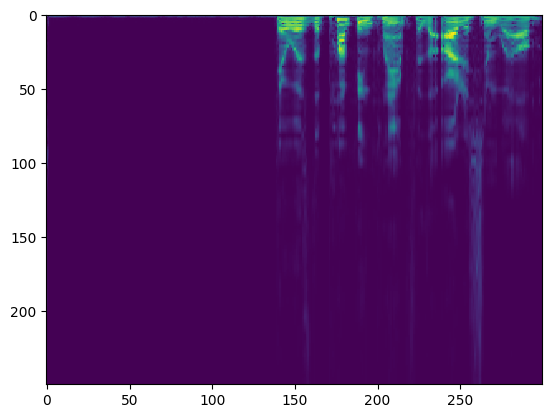

In [103]:
imshow((flattened_truth.abs()).log1p()[0,:250,:300],interpolation="nearest",aspect='auto')

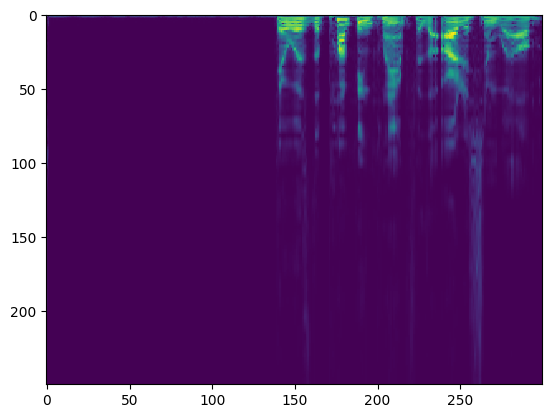

In [104]:
imshow((flattened_best_possible.abs()).log1p()[0,:250,:300],interpolation="nearest",aspect='auto')

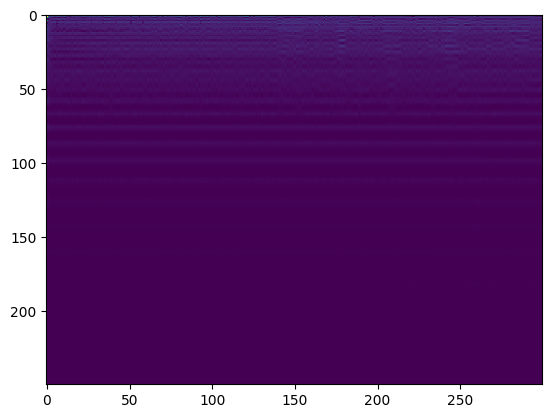

In [105]:
imshow((flattened_prediction.abs()).log1p()[0,:250,:300],interpolation="nearest",aspect='auto')

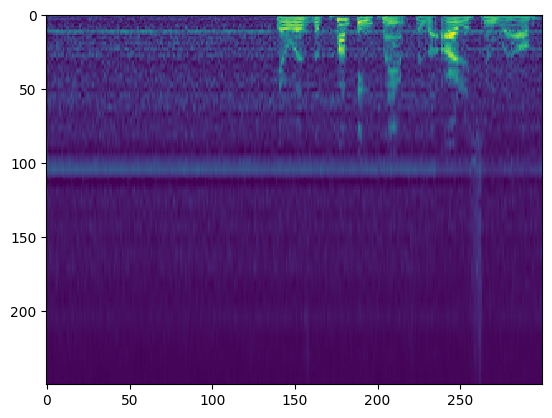

In [106]:
imshow((flattened_perceived.abs()).log1p()[0,:250,:300],interpolation="nearest",aspect='auto')

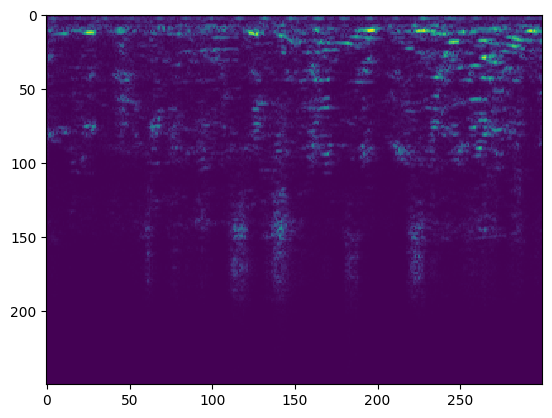

In [76]:
imshow((T0(flattened_noise.cuda()).abs()).log1p()[0,:250,:300],interpolation="nearest",aspect='auto')

In [10]:
devices = sd.query_devices()

# Print the supported sample rates for each device
for idx, device in enumerate(devices):
    name = device.get('name','-')
    default_samplerate = device.get('default_samplerate','-')
    max_input_channels = device.get('max_input_channels','-')
    max_output_channels = device.get('max_output_channels','-')
    print(f"{idx}: {name} @ {default_samplerate}Hz I:{max_input_channels} O:{max_output_channels}")

0: Microsoft Sound Mapper - Input @ 44100.0Hz I:2 O:0
1: Voicemeeter Out B3 (VB-Audio Vo @ 44100.0Hz I:8 O:0
2: Voicemeeter Out A5 (VB-Audio Vo @ 44100.0Hz I:8 O:0
3: Voicemeeter Out A2 (VB-Audio Vo @ 44100.0Hz I:8 O:0
4: Voicemeeter Out A1 (VB-Audio Vo @ 44100.0Hz I:8 O:0
5: Voicemeeter Out B2 (VB-Audio Vo @ 44100.0Hz I:8 O:0
6: Voicemeeter Out A4 (VB-Audio Vo @ 44100.0Hz I:8 O:0
7: Voicemeeter Out A3 (VB-Audio Vo @ 44100.0Hz I:8 O:0
8: Voicemeeter Out B1 (VB-Audio Vo @ 44100.0Hz I:8 O:0
9: Microsoft Sound Mapper - Output @ 44100.0Hz I:0 O:2
10: Headphones (High Definition Aud @ 44100.0Hz I:0 O:2
11: Voicemeeter AUX Input (VB-Audio @ 44100.0Hz I:0 O:8
12: Voicemeeter Input (VB-Audio Voi @ 44100.0Hz I:0 O:8
13: LG FHD (NVIDIA High Definition  @ 44100.0Hz I:0 O:2
14: Voicemeeter In 4 (VB-Audio Voic @ 44100.0Hz I:0 O:8
15: Voicemeeter In 5 (VB-Audio Voic @ 44100.0Hz I:0 O:8
16: Voicemeeter In 3 (VB-Audio Voic @ 44100.0Hz I:0 O:8
17: Voicemeeter VAIO3 Input (VB-Aud @ 44100.0Hz I:0 O:8
18:

In [11]:
sd.query_devices()

   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Voicemeeter Out B3 (VB-Audio Vo, MME (8 in, 0 out)
   2 Voicemeeter Out A5 (VB-Audio Vo, MME (8 in, 0 out)
   3 Voicemeeter Out A2 (VB-Audio Vo, MME (8 in, 0 out)
   4 Voicemeeter Out A1 (VB-Audio Vo, MME (8 in, 0 out)
   5 Voicemeeter Out B2 (VB-Audio Vo, MME (8 in, 0 out)
   6 Voicemeeter Out A4 (VB-Audio Vo, MME (8 in, 0 out)
   7 Voicemeeter Out A3 (VB-Audio Vo, MME (8 in, 0 out)
   8 Voicemeeter Out B1 (VB-Audio Vo, MME (8 in, 0 out)
   9 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
< 10 Headphones (High Definition Aud, MME (0 in, 2 out)
  11 Voicemeeter AUX Input (VB-Audio, MME (0 in, 8 out)
  12 Voicemeeter Input (VB-Audio Voi, MME (0 in, 8 out)
  13 LG FHD (NVIDIA High Definition , MME (0 in, 2 out)
  14 Voicemeeter In 4 (VB-Audio Voic, MME (0 in, 8 out)
  15 Voicemeeter In 5 (VB-Audio Voic, MME (0 in, 8 out)
  16 Voicemeeter In 3 (VB-Audio Voic, MME (0 in, 8 out)
  17 Voicemeeter VAIO3 Input (VB-Aud, MME (0 in, 

In [56]:
a=a.to(DEVICE)

In [57]:
T0(a[:,:hop_length*2]).shape

torch.Size([1, 513, 3])

In [99]:
T0(a[:,:hop_length*2-1]).shape

torch.Size([1, 513, 2])

In [100]:
T0(a[:,:win_length-1]).shape

torch.Size([1, 513, 2])

In [61]:
win_length

1024

In [68]:
import os.path
from multiprocessing.connection import Client
from array import array

#reminders:
#first, set default audio out to CABLE INPUT
#second, disable OBS cleaned mic
#18: Realtek HD Audio 2nd output (Realtek(R) Audio) @ 48000.0Hz I:0 O:2
#19: Stereo Mix (Realtek(R) Audio) @ 48000.0Hz I:2 O:0
#20: CABLE Output (VB-Audio Virtual Cable) @ 48000.0Hz I:1 O:0

# Set parameters
sample_rate = 48000  # Match your system's sample rate
channels = (1, 2)  # Stereo

# Use `sd.query_devices()` to find the correct input/output devices
input_device = 60  # Replace with the device index or name for desktop audio (i chose vb audio cable as input)
#Voicemeeter Out B3 (VB-Audio Voicemeeter VAIO), Windows WASAPI (2 in, 0 out)
#Voicemeeter Out B3 (VB-Audio Voicemeeter VAIO) @ 48000.0Hz I:2 O:0
##OLD COMMENT: CABLE Output (VB-Audio Virtual Cable) @ 48000.0Hz I:1 O:0
##OLD COMMENT: CABLE Output (VB-Audio Virtual Cable), Windows WASAPI (1 in, 0 out)
output_device = 44  # Replace with the device index or name for speakers (i chose my headset)
# Headphones (High Definition Audio Device), Windows WASAPI (0 in, 2 out)
# Headphones (High Definition Audio Device) @ 48000.0Hz I:0 O:2
##OLD COMMENT: Realtek HD Audio 2nd output (Realtek(R) Audio) @ 48000.0Hz I:0 O:2
##OLD COMMENT: Realtek HD Audio 2nd output (Realtek(R) Audio), Windows WASAPI 

stop_stream=False
import time

tmp=tqdm(total=1)
outdata_=None
def audio_callback(conn, indata, outdata, frames, time, status):
    #global outdata_
    if status:
        print(status)
    #print("sending indata", indata.shape)
    #tmp.set_description(f"{indata.shape}")
    outdata[:]=indata
    conn.send(indata)
    msg = conn.recv()
    outdata[:msg.shape[0]]=msg



address = ('localhost', 6101)

print("attempting to connect...")
with Client(address) as conn:
    print("connected")
    with sd.Stream(
        samplerate=sample_rate,
        channels=channels,
        dtype='float32',
        #latency='low',
        blocksize=hop_length,  # Adjust block size for latency vs. performance
        callback=lambda *args, **kwargs: audio_callback(conn, *args, **kwargs),
        device=(input_device, output_device)  # Tuple for input and output devices
    ):
        print("Audio processing started. Press Ctrl+C to stop.")
        
        while not stop_stream:
            # This loop keeps the stream running until the stop condition is met.
            pass
        if stop_stream:
            sd.stop()
        if os.path.isfile("stop_file.txt"):
            sd.stop()

  0%|          | 0/1 [00:00<?, ?it/s]

attempting to connect...
connected
Audio processing started. Press Ctrl+C to stop.


KeyboardInterrupt: 

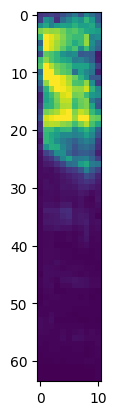

In [97]:
imshow(M0T(T0(a[:,:hop_length*10]).abs()).log1p()[0],vmin=0,vmax=2.5)

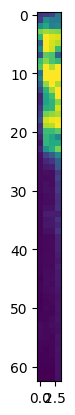

In [98]:
imshow(M0T(T0(a[:,:hop_length*3]).abs()).log1p()[0,:-1],vmin=0,vmax=2.5)

In [82]:
_a=a[:,:win_length]
T0(_a).shape,I0(T0(_a)).shape,_a.shape

(torch.Size([1, 513, 3]), torch.Size([1, 1024]), torch.Size([1, 1024]))

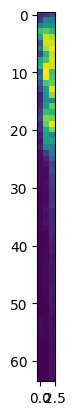

In [86]:
imshow(M0T(T0(_a).abs()).log1p()[0])

In [80]:
_a=a[:,:win_length-1]
T0(_a).shape,I0(T0(_a)).shape,_a.shape

(torch.Size([1, 513, 2]), torch.Size([1, 512]), torch.Size([1, 1023]))

In [79]:
_a=a[:,:hop_length+1]
T0(_a).shape,I0(T0(_a)).shape,_a.shape

(torch.Size([1, 513, 2]), torch.Size([1, 512]), torch.Size([1, 513]))

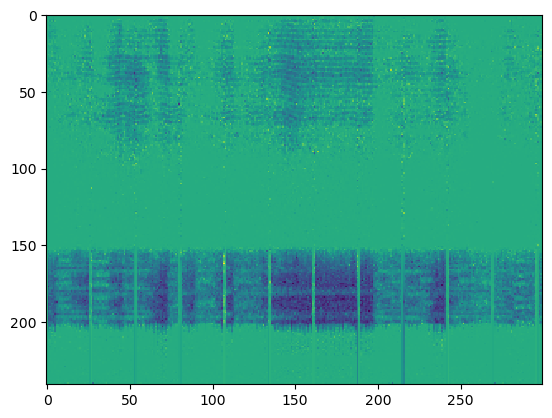

In [341]:
imshow((((flattened_truth).abs()+eps).log()-(flattened_perceived.abs()+eps).log())[0,:,:300],interpolation="nearest",aspect='auto')

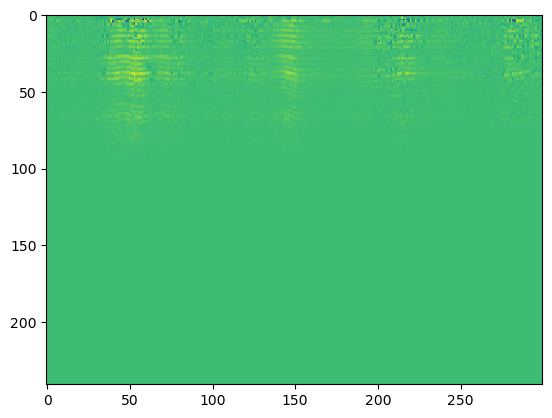

In [346]:
imshow((((flattened_perceived).abs()-flattened_truth.abs()+1).log())[0,:,:300],interpolation="nearest",aspect='auto')

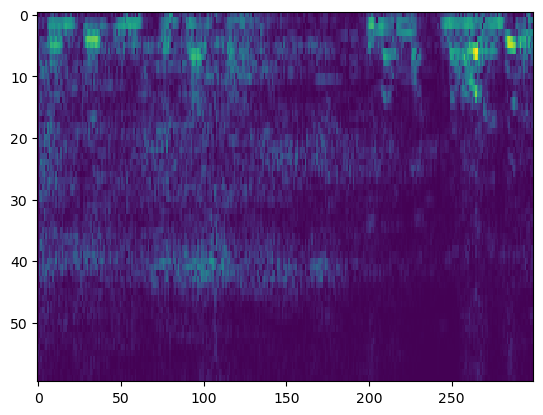

In [224]:
imshow(flattened_perceived.abs().log1p()[0,:60,:300],interpolation="nearest",aspect='auto')

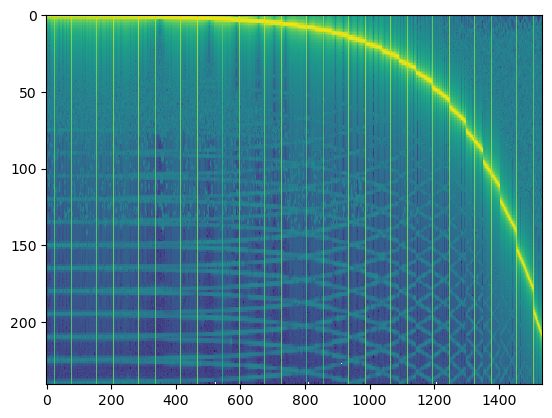

In [41]:
imshow(T(flattened_tmps.cpu()).abs().log()[0],interpolation="nearest",aspect='auto')

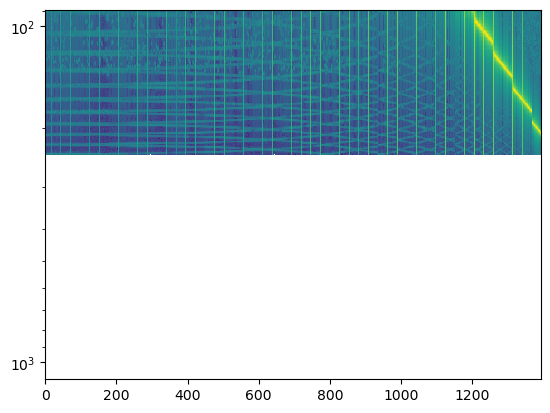

In [47]:
imshow(flattened_zz[0,:,200:].log(),interpolation="nearest",aspect='auto')
plt.yscale('log')

In [ ]:
imshow(flattened_t[0,:150,200:],vmin=0,vmax=4)

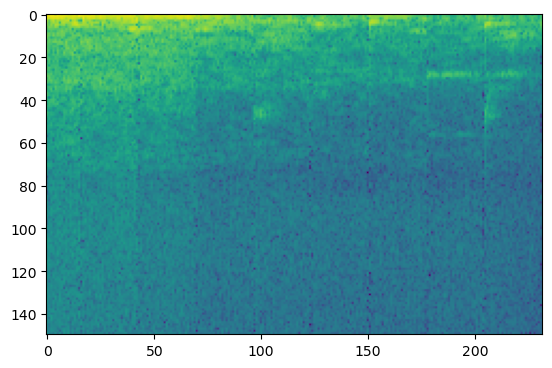

In [177]:
imshow(flattened_zz[0,:150,200:])

In [178]:
flattened_zz.min()

tensor(-inf, device='cuda:0')

In [171]:
flattened_zz.quantile(torch.tensor([0.0,1.0]).to(DEVICE))

tensor([   nan, 1.4566], device='cuda:0')

In [172]:
flattened_truth.quantile(torch.tensor([0.0,1.0]).to(DEVICE))

tensor([   nan, 3.9247], device='cuda:0')

In [173]:
flattened_perceived.quantile(torch.tensor([0.0,1.0]).to(DEVICE))

tensor([   nan, 3.9248], device='cuda:0')

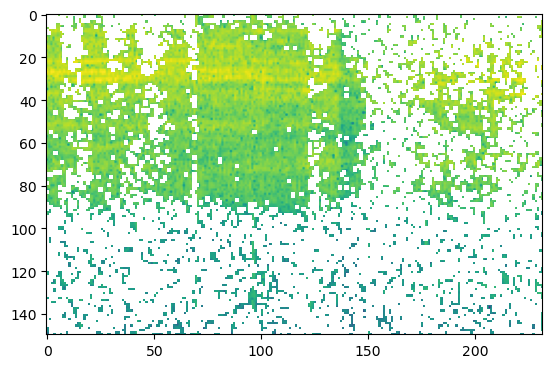

In [164]:
imshow(((flattened_perceived-flattened_truth).log())[0,:150,200:])

In [122]:
(flattened_perceived/flattened_truth).std()

tensor(nan, device='cuda:0')

In [141]:

def normalize(x):
    if len(x.shape)==3:
        return (x)/STDS.to(x.device).view(1,-1,1)
    return (x)/STDS.to(x.device).view(1,1,-1,1)
def denormalize(x):
    if len(x.shape)==3:
        return (x*STDS.to(x.device).view(1,-1,1))
    return (x*STDS.to(x.device).view(1,1,-1,1))
    

In [97]:
play_audio(flattened_truth,SR)

In [47]:
play_audio(flattened_perceived,SR)

ValueError: audio data to be played back must be one- or two-dimensional

In [99]:
play_audio(flattened_prediction,SR)

In [25]:
target.shape,noise.shape,flatten(truth[-1:]).shape

(torch.Size([2, 9958]), torch.Size([1, 9958]), torch.Size([2, 9958]))

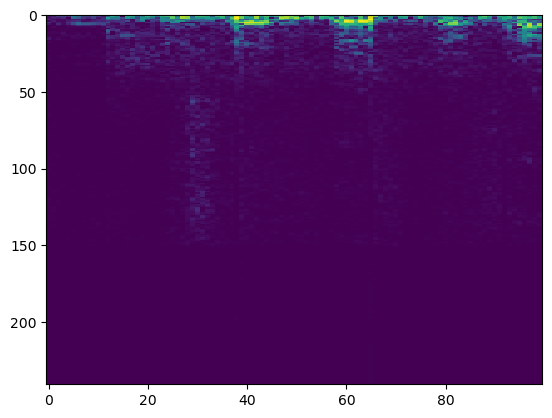

In [152]:
imshow(clamp(denormalize(torch.cat(perceived,-1).abs()))[0,0,:,150:250],interpolation='nearest',aspect='auto')

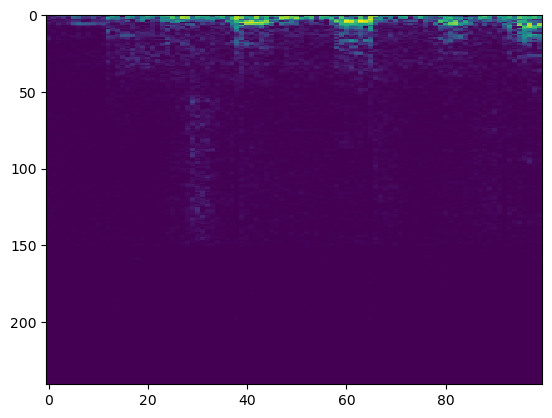

In [153]:
imshow(clamp(denormalize(torch.cat(prediction,-1).abs()))[0,0,:,150:250],interpolation='nearest',aspect='auto')

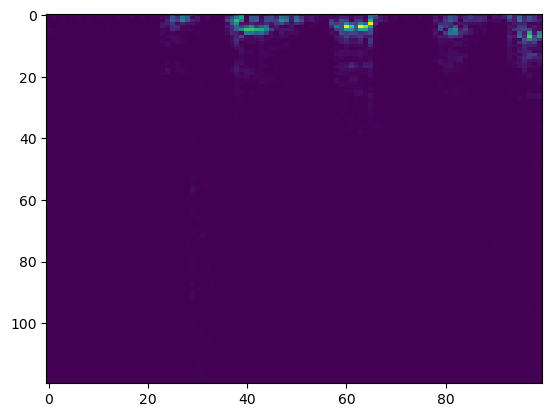

In [154]:
imshow(unclamp(denormalize(torch.cat(truth,-1).abs()))[0,0,:120,150:250],interpolation='nearest',aspect='auto')

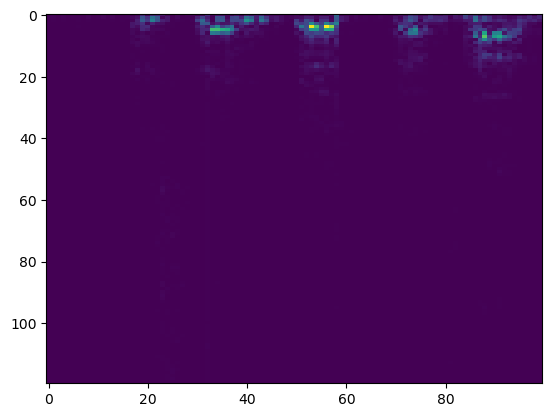

In [151]:
imshow(unwrap_complex(T(flattened_truth2)).abs()[0,0,:120,150:250],interpolation='nearest',aspect='auto')

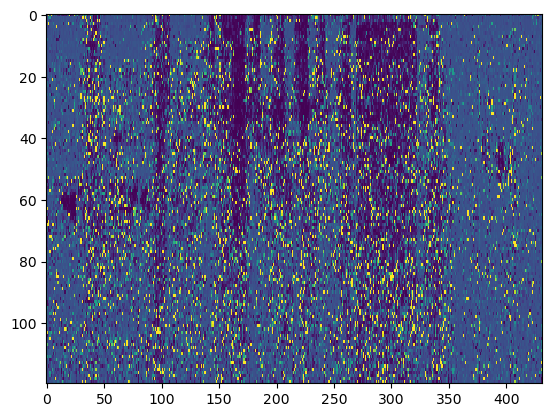

In [155]:
imshow((torch.cat(truth,-1)/torch.cat(prediction,-1)).abs()[0,0,:120],interpolation='nearest',aspect='auto',vmin=0,vmax=4)

In [63]:
(torch.cat(truth,-1)-torch.cat(prediction,-1)).abs().max()

tensor(1.7227, device='cuda:0')

In [42]:
flattened_truth.shape,flattened_truth2.shape

(torch.Size([2, 159328]), torch.Size([2, 159328]))

In [46]:
(flattened_truth-flattened_truth2)

tensor([[-7.8635e-03, -7.7709e-03, -2.2242e-03,  ..., -2.1687e-02,
         -2.7016e-02, -3.1414e-02],
        [-3.5969e-03, -9.6240e-06,  8.7189e-03,  ..., -4.6916e-02,
         -4.9723e-02, -5.1354e-02]])

In [157]:
play_audio(flattened_perceived,48000)

In [156]:
play_audio(flattened_truth,48000)

In [159]:
play_audio(flattened_prediction,48000)

In [108]:
noise_files

['C:\\Users\\umarzein\\Desktop\\audio_codec\\data\\uncompressed\\kaggle_audioNoiseDataset\\sample-1.webm',
 'C:\\Users\\umarzein\\Desktop\\audio_codec\\data\\uncompressed\\kaggle_audioNoiseDataset\\sample-10.webm',
 'C:\\Users\\umarzein\\Desktop\\audio_codec\\data\\uncompressed\\kaggle_audioNoiseDataset\\sample-2.webm',
 'C:\\Users\\umarzein\\Desktop\\audio_codec\\data\\uncompressed\\kaggle_audioNoiseDataset\\sample-3.webm',
 'C:\\Users\\umarzein\\Desktop\\audio_codec\\data\\uncompressed\\kaggle_audioNoiseDataset\\sample-4.webm',
 'C:\\Users\\umarzein\\Desktop\\audio_codec\\data\\uncompressed\\kaggle_audioNoiseDataset\\sample-5.webm',
 'C:\\Users\\umarzein\\Desktop\\audio_codec\\data\\uncompressed\\kaggle_audioNoiseDataset\\sample-6.webm',
 'C:\\Users\\umarzein\\Desktop\\audio_codec\\data\\uncompressed\\kaggle_audioNoiseDataset\\sample-7.webm',
 'C:\\Users\\umarzein\\Desktop\\audio_codec\\data\\uncompressed\\kaggle_audioNoiseDataset\\sample-8.webm',
 'C:\\Users\\umarzein\\Desktop\\audi

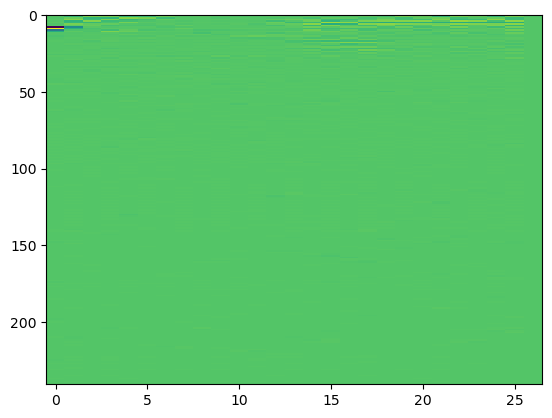

In [28]:
imshow(out[1,1],interpolation='nearest',aspect='auto')

In [30]:
out.mean((-1,-2))

tensor([[ 0.0008, -0.0063],
        [ 0.0017, -0.0066]], device='cuda:0')

In [107]:
out.shape,n.shape

(torch.Size([2, 2, 241, 27]), torch.Size([1, 2, 241, 27]))

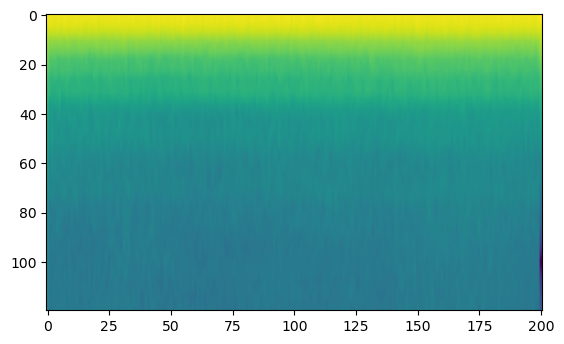

In [39]:
imshow(running_abs_sig[0,0,:120].log())

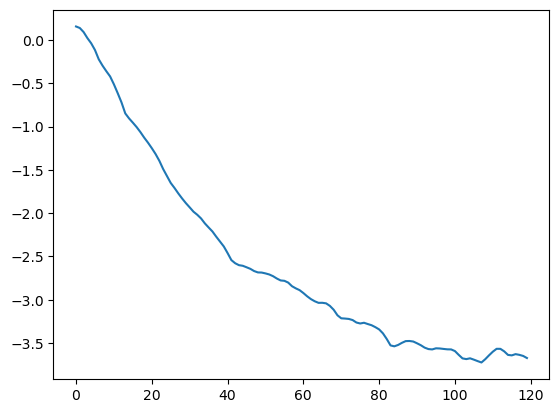

In [46]:
plot(running_abs_sig[0,0,:120].log()[:,0])

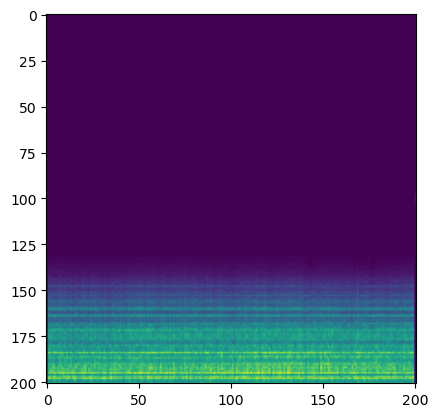

In [35]:
imshow((running_abs_diff/running_abs_sig)[0,0])

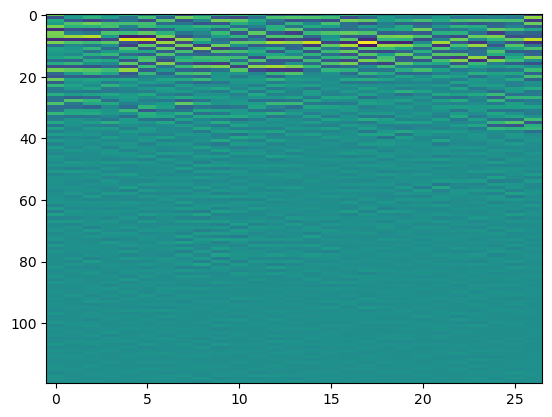

In [15]:
tmp=(y)[0,0,:120]
imshow(tmp,vmin=-tmp.abs().max(), vmax=tmp.abs().max(),interpolation='nearest',aspect='auto')

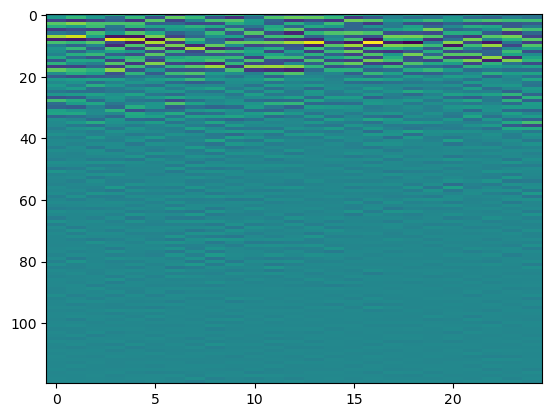

In [16]:
tmp=(out)[0,0,:120,1:-1]
imshow(tmp, interpolation='nearest', aspect='auto')

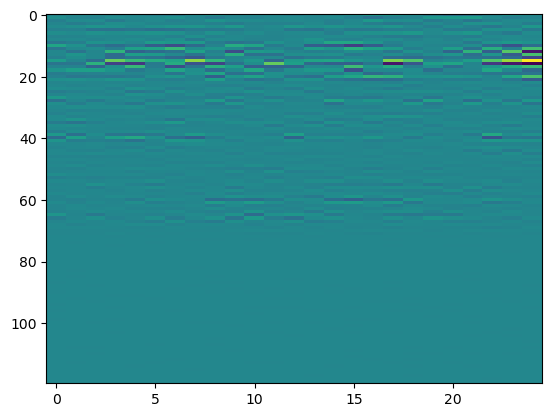

In [99]:
tmp=(z)[0,0,:120,1:-1]
imshow(tmp, interpolation='nearest', aspect='auto')

In [152]:
(out)[0,0,:,:-1].shape

torch.Size([241, 26])

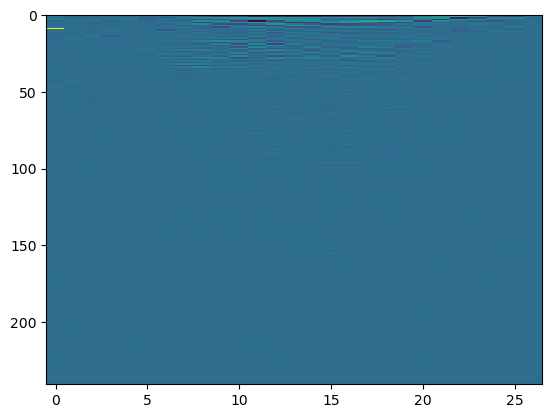

In [18]:
imshow((out)[0,0,:,:],interpolation='nearest',aspect='auto')

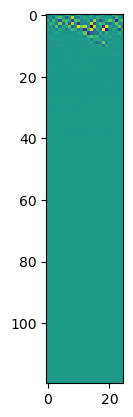

In [134]:
imshow((combined-out-y)[0,0,:120,1:-1])

In [78]:
(y-out).std()

tensor(0.2888, device='cuda:0')

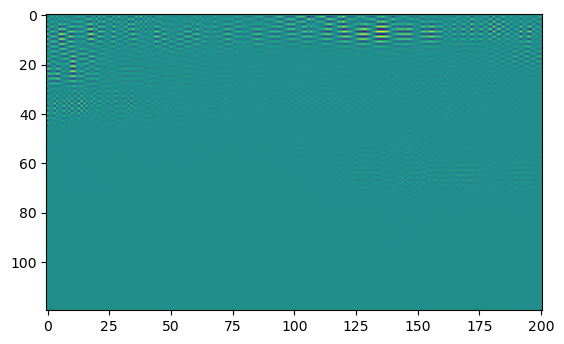

In [27]:
imshow((combined-y)[0,0,:120])

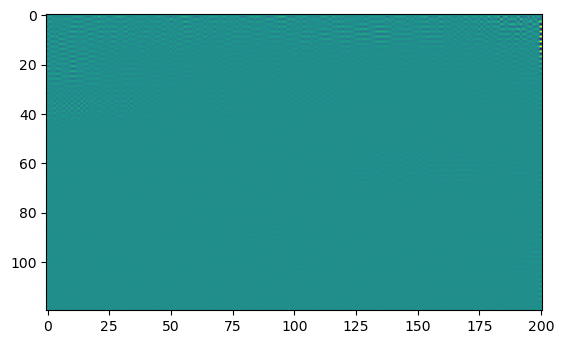

In [30]:
imshow((combined-out)[0,0,:120])

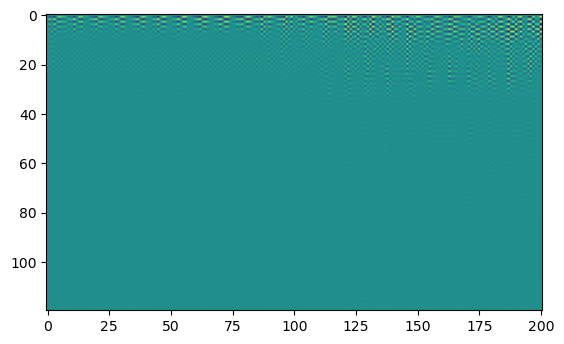

In [20]:
imshow((combined)[0,0,:120])

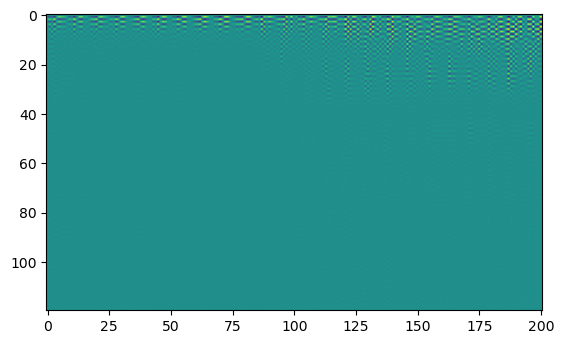

In [21]:
imshow((y)[0,0,:120])

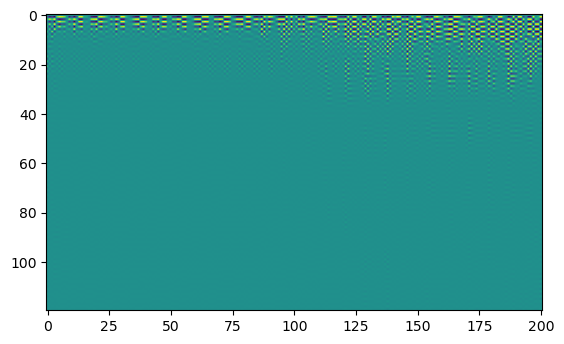

In [22]:
imshow((out)[0,0,:120])

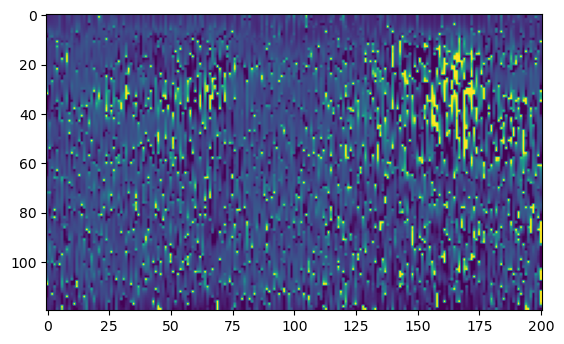

In [54]:
imshow(((out/y).clip(0,4)[0,0,:120]))

In [39]:
((out/y)[0,0,:120]).abs().max()

tensor(10359.4316, device='cuda:0')

In [30]:
((y-out)[0,0]).std()

tensor(0.0567, device='cuda:0', grad_fn=<StdBackward0>)

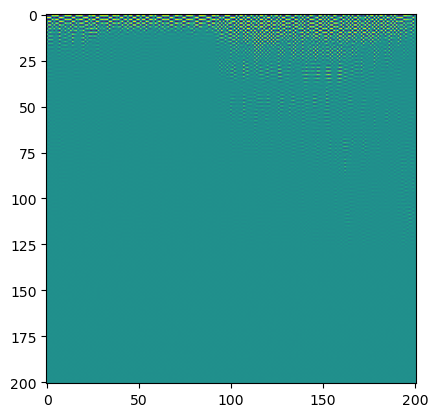

In [36]:
imshow(out[0,0])

<Axes: >

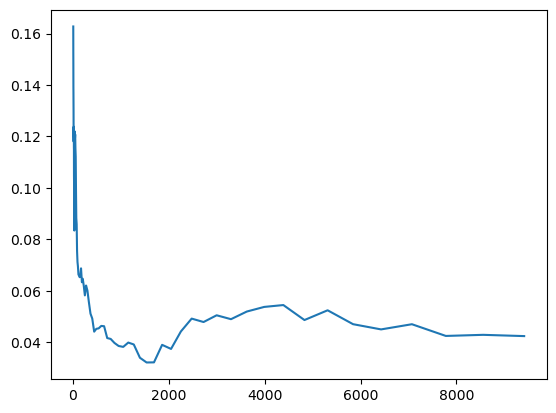

In [36]:
pd.Series(model.train_loss_record).rolling(10).mean().plot()

**Identity Test for Neural Networks**


1. let $\mathbb{T}$ denote a set of all homogenous real-valued $n$-dimensional array, where $n$ is arbitrary, (i.e., a tensor space). $\mathbb{T}$ might be either $\mathbb{R}, \mathbb{R}^N, \mathbb{R}^{N \times M}, \dots$
2. let there be a function $f: \mathbb{T} \rightarrow \mathbb{T}$
4. let $\Phi$ denote a neural network with a parameter-space $\mathbb{\Theta}$:
$$
\Phi: \mathbb{T} \times \mathbb{\Theta} \rightarrow \mathbb{T}
$$
5. if there exists a non-empty set $\mathcal{G} = \{ x | x \in \mathbb{T}, f(x)=x\}$
6. if $\Phi$ should be able to at least approximate $\Phi(x,\theta)=x$
7. therefore,
    $$
    \min\limits_{\theta^*}\mathrm{E}\left[||\Phi(x, \theta^*)-f(x)||\right] \ge 
               \min\limits_{\theta_\gamma^*, \gamma \in \mathcal{G}}              ||\Phi(\gamma, \theta_\gamma^*)-\gamma||
    $$
8. $\mathbb{\Theta}$ typically converges faster if the function to approximate is $g(x)=x$
9. therefore, typically, we can survey the model's capability quickly by observing its training over $\mathcal{G}$

<Axes: >

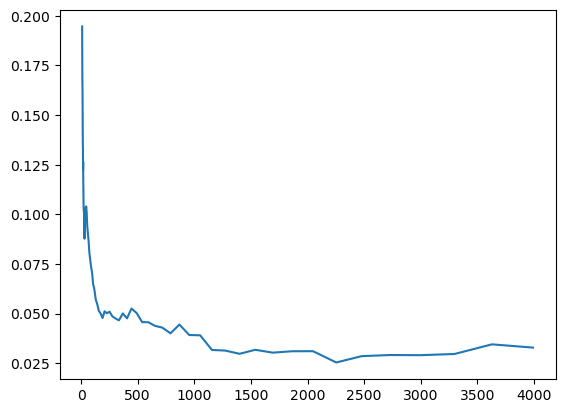

In [27]:
pd.Series(model.train_loss_record).rolling(10).mean().plot()

In [33]:
torch.save(model.state_dict(),"RUNet2.pth")

In [4]:
sd.query_devices()

   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Stereo Mix (Realtek(R) Audio), MME (2 in, 0 out)
   2 CABLE Output (VB-Audio Virtual , MME (8 in, 0 out)
   3 Microphone (Realtek(R) Audio), MME (2 in, 0 out)
   4 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  5 CABLE Input (VB-Audio Virtual C, MME (0 in, 8 out)
   6 24E3 (NVIDIA High Definition Au, MME (0 in, 2 out)
   7 Realtek HD Audio 2nd output (Re, MME (0 in, 2 out)
   8 Primary Sound Capture Driver, Windows DirectSound (2 in, 0 out)
   9 Stereo Mix (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
  10 CABLE Output (VB-Audio Virtual Cable), Windows DirectSound (8 in, 0 out)
  11 Microphone (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
  12 Primary Sound Driver, Windows DirectSound (0 in, 2 out)
  13 CABLE Input (VB-Audio Virtual Cable), Windows DirectSound (0 in, 8 out)
  14 24E3 (NVIDIA High Definition Audio), Windows DirectSound (0 in, 2 out)
  15 Realtek HD Audio 2nd output (Realtek(R) Audio), Win

In [33]:
outdata_2=(outdata_*1000).clip(-1,1)
play_audio((outdata_2.T).repeat(10,1), SR)

In [20]:
outdata_.var()

1.0450775e-09

In [83]:
with sd.Stream() as stream:
    print("Input device:", stream.input_device)
    print("Input channels:", stream.input_channels)
    print("Output device:", stream.output_device)
    print("Output channels:", stream.output_channels)

AttributeError: 'Stream' object has no attribute 'input_device'

In [86]:
(stream)._device

(1, 5)

In [120]:
torch.save(model.state_dict(),"good_small_model2.pth")
torch.save(model,"good_small_model2.pkl")

In [73]:
for inner in ('unet1d','unet2d','mlp','scaler'):
    print(inner,sum(p.numel() for p in getattr(model,inner).parameters() if p.requires_grad))

unet1d 947062
unet2d 1592396
mlp 711140
scaler 266468


In [87]:
for inner in ('unet2d','mlp','scaler'):
    print(inner,sum(p.numel() for p in getattr(model,inner).parameters() if p.requires_grad))

unet2d 1592396
mlp 505316
scaler 266468


In [90]:
sum(p.numel() for p in model.parameters() if p.requires_grad)/1024/1024

2.254657745361328

In [60]:
tmp.index.astype(int)

Index([    1,     1,     1,     1,     1,     1,     1,     1,     2,     2,
       ...
        7778,  8556,  9412, 10353, 11388, 12527, 13780, 15158, 16674, 18341],
      dtype='int32', length=104)

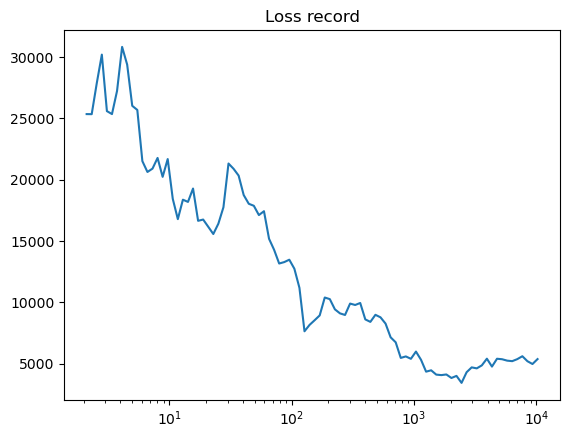

In [80]:
tmp=pd.Series(loss_record)
tmp=pd.DataFrame({
    "loss":tmp,
    "t":1.1**tmp.index
})
tmp=tmp.rolling(15).mean()
plt.plot(tmp['t'],tmp['loss'])
plt.xscale('log')
plt.title("Loss record")
plt.gcf().savefig("loss_record1.svg")
#_=plt.xticks(list(map(lambda x:x**1.1,range(len(loss_record))))[::20])

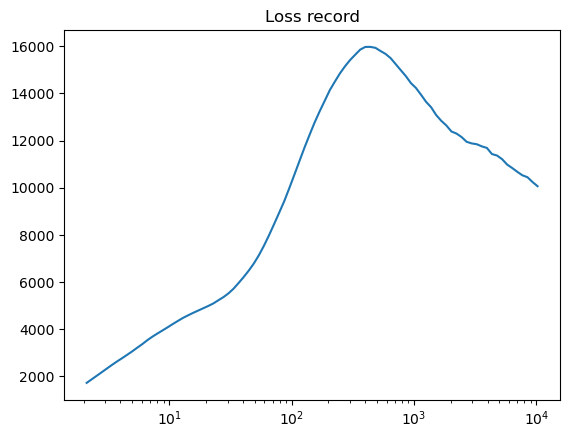

In [115]:
tmp=pd.Series(loss_record)
tmp=pd.DataFrame({
    "loss":tmp,
    "t":1.1**tmp.index
})
tmp=tmp.rolling(15).mean()
plt.plot(tmp['t'],tmp['loss'])
plt.xscale('log')
plt.title("Loss record")
plt.gcf().savefig("loss_record2.svg")
#_=plt.xticks(list(map(lambda x:x**1.1,range(len(loss_record))))[::20])

In [62]:
tmp

loss             t
0     4936.026367      1.000000
1    23668.457031      1.100000
2     1344.815674      1.210000
3    72129.593750      1.331000
4     8521.057617      1.464100
..            ...           ...
99    3219.941162  12527.829400
100   6489.428711  13780.612340
101    722.797119  15158.673574
102   2090.786621  16674.540931
103   6275.453613  18341.995024

[104 rows x 2 columns]

In [191]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [217]:
(y-out).var()

tensor(0.0027, device='cuda:0', grad_fn=<VarBackward0>)

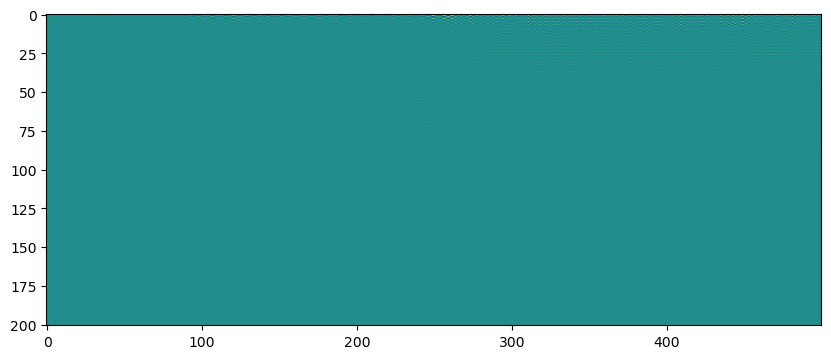

In [256]:
with figsize_as(10.0,10.0):
    #imshow(denormalize(unclamp(combined))[0,0,:,:100])
    #plt.show()
    #imshow(denormalize(unclamp(out))[0,0,:,:100])
    #plt.show()
    ##X_=X.clone()
    ##std=X_.std((0,1,-1)).reshape(1,1,-1,1)
    ##mean=X_.mean((0,1,-1)).reshape(1,1,-1,1)
    ##X_=(X_-mean)/std
    #imshow(denormalize(unclamp(y))[0,0,:,:100])
    #plt.show()
    imshow(denormalize(unclamp(y-out))[0,0,:,:500])
    plt.show()
    #imshow(normalize(((out)[0,0])-((X)[0,0])))

In [245]:
combined[0,0].std(-1)

tensor([0.5925, 0.6285, 0.8891, 0.9912, 0.8792, 0.8162, 0.7507, 0.6795, 0.6289,
        0.6010, 0.6258, 0.6478, 0.6547, 0.6563, 0.6019, 0.6190, 0.6044, 0.6083,
        0.6302, 0.6653, 0.7088, 0.6778, 0.7002, 0.7424, 0.7449, 0.7160, 0.7057,
        0.6500, 0.6164, 0.6430, 0.6607, 0.6584, 0.6635, 0.6445, 0.7204, 0.7260,
        0.7173, 0.6584, 0.6871, 0.7255, 0.7723, 0.7086, 0.7519, 0.8182, 0.7740,
        0.7765, 0.7502, 0.7283, 0.6767, 0.6028, 0.5871, 0.5638, 0.5610, 0.5710,
        0.5728, 0.5652, 0.6002, 0.6318, 0.6266, 0.6276, 0.6123, 0.5954, 0.5472,
        0.5526, 0.5459, 0.5094, 0.4773, 0.5279, 0.5821, 0.5773, 0.5817, 0.5843,
        0.5886, 0.5814, 0.5646, 0.5746, 0.5483, 0.5274, 0.4998, 0.4686, 0.4370,
        0.4556, 0.4485, 0.4219, 0.4457, 0.4527, 0.4414, 0.4460, 0.4496, 0.4596,
        0.4455, 0.4294, 0.4147, 0.3888, 0.3896, 0.3832, 0.3846, 0.3583, 0.3470,
        0.3391, 0.3414, 0.3237, 0.3366, 0.3375, 0.3380, 0.3488, 0.3609, 0.3689,
        0.3616, 0.3563, 0.3459, 0.3254, 

In [197]:

target_gen = (stream_audio("perfect_vocals.mp3", buffer_size=3*SR, skip_samples=11*SR))
noise_gen = (stream_audio("invisible_light_instrumental.mp3", buffer_size=3*SR, skip_samples=11*SR))

for (target, sr1), (noise, sr2) in tqdm(zip(target_gen, noise_gen)):
    if sr1!=sr2:
        #print("sample rates are different")
        continue
    if (target.shape!=noise.shape):
        #print("sample sizes are different")
        continue
    combined=clamp(normalize(unwrap_complex(T(target*0.9+noise*0.1))))
    y=clamp(normalize(unwrap_complex(T(target))))
    #combined, sr = combine_audio((target, sr1), (noise, sr2))
    with torch.no_grad():
        out=model(combined)
    play_audio(I(wrap_complex(denormalize(unclamp(combined)))).repeat(1,1),SR)
    play_audio(I(wrap_complex(denormalize(unclamp(out)))).repeat(1,1),SR)
    #play_audio(I(wrap_complex(denormalize(unclamp(y)))).repeat(1,1),SR)
    

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [124]:
I(wrap_complex(denormalize(unclamp(out)))).shape

torch.Size([2, 3450])

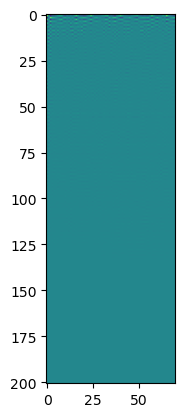

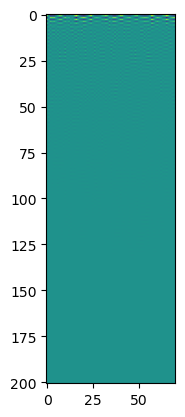

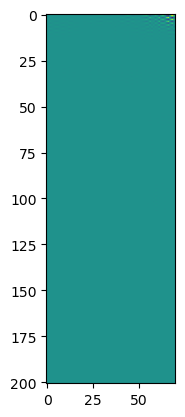

In [117]:
imshow(denormalize(unclamp(out))[0,0])
plt.show()
imshow(denormalize(unclamp(combined))[0,0])
plt.show()
imshow(denormalize(unclamp(y))[0,0])

In [54]:
gen=stream_audio("")

NameError: name 'samples' is not defined

In [177]:
[1,2,3,4][1:-1]

[2, 3]

In [216]:
import gc
del model
gc.collect()
torch.cuda.empty_cache()

In [217]:
2<<9

1024

In [53]:
class MLP(nn.Module):
    def __init__(self, input_dim, dims, output_dim, activation=nn.Tanh, final_activation=nn.Tanh, dropout_rate=0.1):
        super().__init__()
        self.dims=[input_dim]+dims+[output_dim]
        self.do_rate=dropout_rate
        self.layers = nn.Sequential(
            *[
                x
                for xs in [(
                    nn.Linear(self.dims[i],self.dims[i+1]),
                    activation(),
                    nn.Dropout(self.do_rate),
                ) if i+1<len(self.dims)-1 else (
                    nn.Linear(self.dims[i],self.dims[i+1]),
                    final_activation(),
                    nn.Dropout(self.do_rate),
                ) if final_activation is not None else (
                    nn.Linear(self.dims[i],self.dims[i+1]),
                    nn.Dropout(self.do_rate),
                )  for i in range(len(self.dims)-1)]
                for x in xs
            ]
        )
    def forward(self, x):
        return self.layers(x)

In [79]:
class ConvMLP(nn.Module):
    def __init__(self, in_channel, channels, out_channel, kernel_size, stride=1, padding=0, bias=True):
        super().__init__()
        layers=[]
        __c=[in_channel,*channels,out_channel]
        for c1,c2 in itertools.pairwise(__c):
            layers.append(nn.Conv1d(c1,c2, kernel_size, stride=stride, padding=padding, bias=bias))
            layers.append(nn.Tanh())
        self.layers=nn.Sequential(*layers)
    def forward(self, x):
        return self.layers(x)[...,:x.shape[-1]]

class AudioModel(nn.Module):
    def __init__(self, channels, mlp_dims):
        super().__init__()
        self.nn = nn.RNN(2,mlp_dims[0])
        self.mlp = MLP(mlp_dims[0], mlp_dims[1:-1], mlp_dims[-1])
    def forward(self, x):
        out,_ = self.nn(x.transpose(0,-1))
        return self.mlp(out).transpose(0,-1)#[...,:x.shape[-1]]

In [13]:
taishou_a_instrumental = stream_audio("taishou_a_instrumental.mp3")

In [12]:
perfect_vocals = stream_audio("perfect_vocals.mp3")

In [80]:
AudioModel(2, [5,10,2])(combined).shape

torch.Size([2, 47])

In [218]:
model=UNet()
for i in (480, 500, 512, 890, 891, 1000, 1024):
    tmp=model(a[0][...,:i])
    print(i, tmp.shape)

480 torch.Size([2, 480])
500 torch.Size([2, 500])
512 torch.Size([2, 512])
890 torch.Size([2, 890])
891 torch.Size([2, 891])
1000 torch.Size([2, 1000])
1024 torch.Size([2, 1024])


In [5]:
a

NameError: name 'a' is not defined

In [5]:
KERNEL_SIZEWF=5
#PADDING=0
STRIDEWF=3

class UNetWaveform(nn.Module):
    def __init__(self, chnls_in=2, chnls_out=2, dropout=0.01, kernel_size=KERNEL_SIZEWF):
        super().__init__()

        I=chnls_in
        B=1024
        C=512
        D=1024
        E=512
        O=chnls_out

        self.batch_norm = nn.BatchNorm1d(I)
        
        self.down_conv_layer_1 = DownConvBlockWaveform(I, B, kernel_size=kernel_size, dropout=dropout)
        self.down_conv_layer_2 = DownConvBlockWaveform(B, C, kernel_size=kernel_size, dropout=dropout)
        self.down_conv_layer_3 = DownConvBlockWaveform(C, D, kernel_size=kernel_size, dropout=dropout)
        self.down_conv_layer_4 = DownConvBlockWaveform(D, C, kernel_size=kernel_size, dropout=dropout)
        self.down_conv_layer_5 = DownConvBlockWaveform(C, D, kernel_size=kernel_size, dropout=dropout)
        self.down_conv_layer_6 = DownConvBlockWaveform(D, E, kernel_size=kernel_size, dropout=dropout)

        self.up_conv_layer_1   = UpConvBlockWaveform   (E,   D, kernel_size=kernel_size, dropout=dropout)# 256+256 6 5 kernel_size=(2, 3), stride=2, padding=0
        self.up_conv_layer_2   = UpConvBlockWaveform   (D+D, C, kernel_size=kernel_size, dropout=dropout) # 256+256 1 4
        self.up_conv_layer_3   = UpConvBlockWaveform   (C+C, D, kernel_size=kernel_size, dropout=dropout) # 2 3
        self.up_conv_layer_4   = UpConvBlockWaveform   (D+D, C, kernel_size=kernel_size, dropout=dropout) # 3 2
        self.up_conv_layer_5   = UpConvBlockWaveform   (C+C, B, kernel_size=kernel_size, dropout=dropout) # 4 1
        self.up_last           = nn.ConvTranspose1d    (B+B, O, kernel_size=kernel_size, stride=STRIDEWF, padding=0)
        
        #self.upsample_layer = nn.Upsample(scale_factor=2)
        #self.zero_pad = nn.ZeroPad1d(8)
        #self.activation = nn.Tanh()
    
    def forward(self, x):
        seq_len=x.shape[-1]
        #normalized_x=self.batch_norm(x)
        #print("doing down_conv_layer_1", x.shape)
        enc1 = self.down_conv_layer_1(x)
        #print("doing down_conv_layer_2", enc1.shape)
        enc2 = self.down_conv_layer_2(enc1) 
        #print("doing down_conv_layer_3", enc2.shape)
        enc3 = self.down_conv_layer_3(enc2)
        #print("doing down_conv_layer_4", enc3.shape)
        enc4 = self.down_conv_layer_4(enc3)
        #print("doing down_conv_layer_5", enc4.shape)
        enc5 = self.down_conv_layer_5(enc4)
        #print("doing down_conv_layer_6", enc5.shape)
        enc6 = self.down_conv_layer_6(enc5)
 
        #print("doing up_conv_layer_1", enc6.shape)
        dec1 = self.up_conv_layer_1(enc6, enc5)
        #print("doing up_conv_layer_2", dec1.shape)
        dec2 = self.up_conv_layer_2(dec1, enc4)
        #print("doing up_conv_layer_3", dec2.shape)
        dec3 = self.up_conv_layer_3(dec2, enc3)
        #print("doing up_conv_layer_4", dec3.shape)
        dec4 = self.up_conv_layer_4(dec3, enc2)
        #print("doing up_conv_layer_5", dec4.shape)
        dec5 = self.up_conv_layer_5(dec4, enc1)

        #print("doing upsample_layer", dec5.shape)
        #final = self.upsample_layer(dec5)
        #print("doing zero_pad", dec5.shape)
        #final = self.zero_pad(dec5)
        #print("doing up_last", dec5.shape)
        final=self.up_last(dec5)
        #print("final:",final.shape)
        final = final[...,:seq_len].tanh()
        #print("returning",final.shape)
        
        return (final)

class UpConvBlockWaveform(nn.Module):
    def __init__(self, ip_sz, op_sz, kernel_size=KERNEL_SIZEWF, stride=STRIDEWF, padding=0, output_padding=0 ,dropout=None):
        super().__init__()
        self.layers = [
            nn.ConvTranspose1d(ip_sz, op_sz, kernel_size=kernel_size, padding=padding, stride=stride, output_padding=output_padding),
            #nn.InstanceNorm1d(op_sz),
            nn.Tanh(),
        ]
        if dropout:
            self.layers += [nn.Dropout(dropout)]
        self.layers=nn.Sequential(*(self.layers))
    def forward(self, x, enc_ip):
        #print("    x:",x.shape)
        #print("    enc_ip:",enc_ip.shape)
        #print("    doing sequentilal", x.shape)
        x = self.layers(x)
        #print("    result of sequentilal", x.shape)
        #print("    doing cat", x[...,:enc_ip.shape[-1]].shape, enc_ip.shape)
        op = torch.cat((x[...,:enc_ip.shape[-1]], enc_ip), -2)
        #print("    returning",op.shape)
        return op


class DownConvBlockWaveform(nn.Module):
    def __init__(self, ip_sz, op_sz, kernel_size=KERNEL_SIZEWF, stride=STRIDEWF, padding=1, norm=False, dropout=None):
        super().__init__()
        self.layers = [nn.Conv1d(ip_sz, op_sz, kernel_size, stride=stride, padding=padding)]
        if norm:
            self.layers.append(nn.InstanceNorm1d(op_sz))
        self.layers += [nn.LeakyReLU(0.2)]
        if dropout:
            self.layers += [nn.Dropout(dropout)]
        self.layers=nn.Sequential(*(self.layers))
    def forward(self, x):
        op = self.layers(x)#[...,:-1]
        return op

In [13]:
SR//20

2400

In [39]:
#model=UNetWaveform()
model=MLP(
    SR//20,
    [],
    SR//20
)
optimizer=torch.optim.AdamW(model.parameters(),lr=1e-3)

In [40]:
def transform(x):
    return (MU(x)-128)/128
def inverse_transform(x):
    return IMU(x*128+128)

In [41]:
from tqdm.auto import tqdm
n_epochs=20
IGNORE_PADS=9
running_loss=0
running_loss_window=200
BUFFER_SIZE=SR//20
with tqdm(total=n_epochs) as epoch_i:
    with tqdm(total=1) as iteration_i:
        epoch_i.reset(n_epochs)
        for epochs in range(n_epochs):
            target_file = "perfect_vocals.mp3"
            noise_file = "invisible_light_instrumental.mp3"
            
            iteration_i.reset(get_num_samples(target_file))
            iteration_i.refresh()
            target_gen = (stream_audio(target_file, buffer_size=BUFFER_SIZE))
            noise_gen = (stream_audio(noise_file, buffer_size=BUFFER_SIZE))
            for (target, sr1), (noise, sr2) in (zip(target_gen, noise_gen)):
                if sr1!=sr2:
                    continue
                if (target.shape!=noise.shape):
                    continue
                target=target[...,:BUFFER_SIZE]#target=target[...,:BUFFER_SIZE].unflatten(-1,(SR//20,-1)).permute(-1,0,1)
                noise=noise[...,:BUFFER_SIZE]#noise=noise[...,:BUFFER_SIZE].unflatten(-1,(SR//20,-1)).permute(-1,0,1)
                iteration_i.update(target.shape[-1])
                rn=torch.rand([])
                combined=transform(rn*target+(1-rn)*noise)
                out=model(combined)
                loss=((out-combined)**2).sum()
                loss_ = float(loss.item())
                running_loss = loss_/running_loss_window+(1-1/running_loss_window)*running_loss
                model.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()
                iteration_i.set_description(f'SSE={loss_:08.2f}')
                epoch_i.set_description(f'running SSE={running_loss:08.2f}')
            epoch_i.update(1)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [194]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [180]:
torch.rand([])

tensor(0.7512, device='cuda:0')

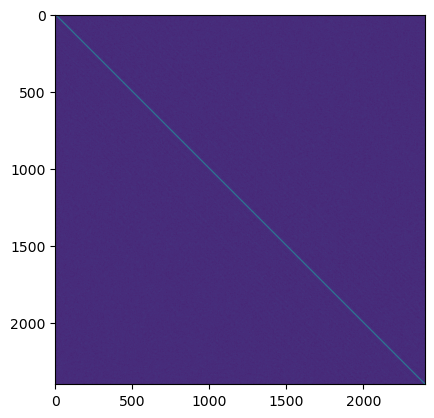

In [43]:
imshow(model.layers[0].weight)

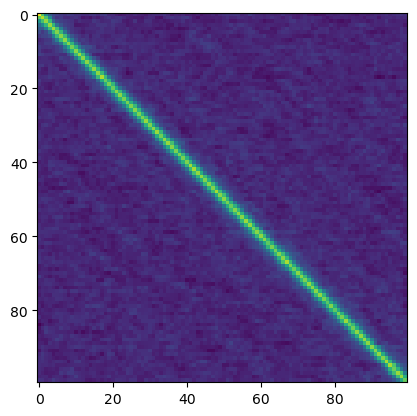

In [42]:
imshow(model.layers[0].weight[:100,:100])

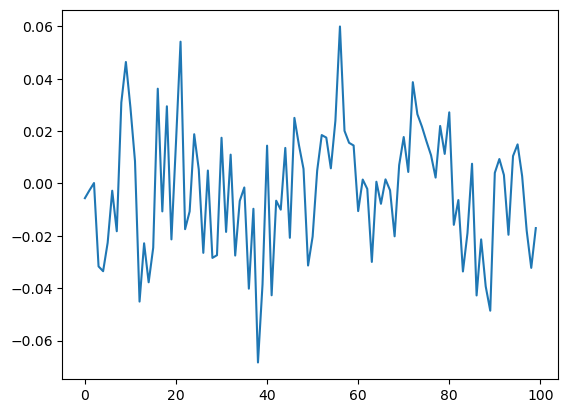

In [44]:
plot(model.layers[0].bias[:100])

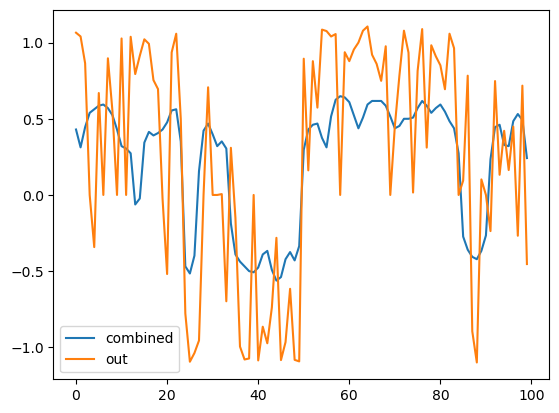

In [45]:
plot(combined[0,:100],label='combined')
plot(out[0,:100],label='out')
plt.legend()

In [33]:
from tqdm.auto import tqdm
BUFFER_SIZE=SR
target_file = "perfect_vocals.mp3"
noise_file = "invisible_light_instrumental.mp3"
target_gen = (stream_audio(target_file, buffer_size=BUFFER_SIZE, skip_samples=SR*11))
noise_gen = (stream_audio(noise_file, buffer_size=BUFFER_SIZE, skip_samples=SR*11))
for (target, sr1), (noise, sr2) in (zip(target_gen, noise_gen)):
    if sr1!=sr2:
        continue
    if (target.shape!=noise.shape):
        continue
    iteration_i.update(target.shape[-1])
    rn=0.7
    combined=(MU(rn*target+(1-rn)*noise)-128)/128
    y=(MU(target)-128)/128
    out=model(combined)
    play_audio(IMU(combined*128+128),sr1)
    play_audio(IMU(y*128+128),sr1)
    play_audio(IMU(out*128+128),sr1)
    break

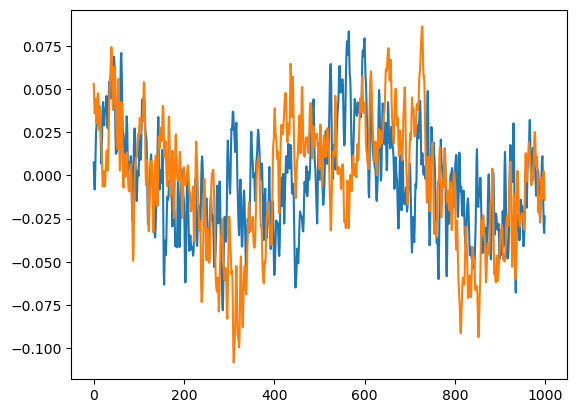

In [17]:
plot(combined[0,:1000])
plot(combined[1,:1000])

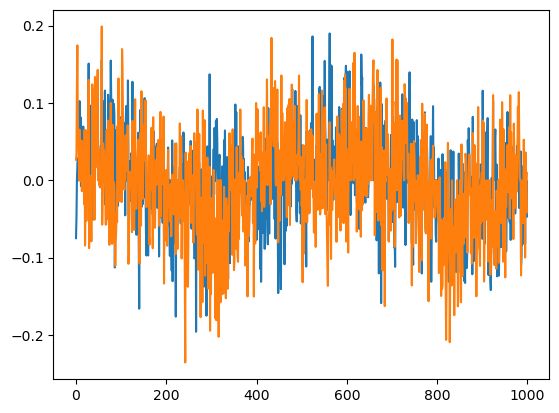

In [18]:
plot(out[0,:1000])
plot(out[1,:1000])

In [35]:
out[...,:30].T

tensor([[-1.,  1.],
        [ 1.,  1.],
        [ 1., -1.],
        [-1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.],
        [-1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.],
        [-1.,  1.],
        [ 1.,  1.],
        [ 1., -1.],
        [-1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.],
        [-1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.],
        [-1.,  1.],
        [ 1.,  1.],
        [ 1., -1.],
        [-1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.],
        [-1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.],
        [-1.,  1.],
        [ 1.,  1.],
        [ 1., -1.]], device='cuda:0', grad_fn=<PermuteBackward0>)

In [107]:
(MU(torch.tensor([-1,-.9,-.5,-.1,0,.1,.5,.9,1]))-128)/128

tensor([-1.0000, -0.9844, -0.8750, -0.5938,  0.0000,  0.5859,  0.8672,  0.9766,
         0.9922], device='cuda:0')

In [19]:
sample

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [17]:
MU(s)

tensor([[239, 239, 239,  ..., 239, 239, 239],
        [239, 239, 239,  ..., 239, 239, 239]], device='cuda:0')

In [70]:
n_epochs=5000
TRAINING=False
RESET_RECORD=False
IGNORE_PADS=2
running_loss=0
running_loss_window=200
target_gen = stream_random_audio_buffer(target_files, buffer_size=SR*3)#(stream_audio(target_file, buffer_size=SR, skip_samples=11*SR))
noise_gen = stream_random_audio_buffer(noise_files, buffer_size=SR*3)#(stream_audio(noise_file, buffer_size=SR, skip_samples=11*SR))
with tqdm(total=n_epochs) as epoch_i:
    if TRAINING and RESET_RECORD:
        loss_record=[]
    if RESET_RECORD and not TRAINING:
        raise Exception("invalid combination of arguments")
    epoch_i.reset(n_epochs)
    for epochs,((target, sr1), (noise, sr2))  in zip(range(n_epochs), zip(target_gen, noise_gen)):
        rn=torch.rand([])*0.2+0.2
        combined = clamp(normalize(unwrap_complex(T(noise*rn+target*(1-rn)))))
        y = clamp(normalize(unwrap_complex(T(target*(1-rn)))))
        if TRAINING:
            out = model(combined)
            
            loss=denormalize(((out-y))**2)[...,IGNORE_PADS:-IGNORE_PADS].mean(-1).sum()
            loss_ = float(loss.item())
            running_loss = (1/running_loss_window)*loss_+(1-1/running_loss_window)*running_loss
            if epochs>1.1**len(loss_record):
                loss_record.append(running_loss)
            model.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
            epoch_i.set_description(f'running SSE={running_loss:.2f}')
        else:
            #rn=(rn+0.3)/2.0
            with torch.no_grad():
                out = model(combined)
            epoch_i.set_description(f"playing combined random-strength: {int(rn*100)}")
            play_audio(noise*rn+target*(1-rn), sr1)
            time.sleep(0.2)
            epoch_i.set_description("playing out")
            play_audio(I(wrap_complex(denormalize(unclamp(out)))), sr1)
            time.sleep(0.2)
            epoch_i.set_description("playing target")
            play_audio(target*(1-rn), sr1)
            time.sleep(0.5)
        epoch_i.update(1)

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 